In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pandas._config.config import T

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from collections import Counter

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dropout, Conv1D, MaxPooling1D
from keras.layers import  Dense, Embedding, LSTM, Bidirectional, GRU, Flatten, SimpleRNN

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from tensorflow.python.ops.numpy_ops import np_config

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict, validation_curve, cross_val_score
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
from matplotlib.font_manager import parse_fontconfig_pattern


import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Section 1 Data Exploration & Visualization
---
---



In [ ]:
# training and test dataset split at 70/30
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')

In [ ]:
# Combine into a full dataset for further data exploration
both_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

# Size of dataset
print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}\n'.format(test_df.shape))


Shape Train:	(7352, 563)
Shape Test:	(2947, 563)



In [ ]:
both_df.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-kurtosis()  \
0         -0.923527         -0.934724  ...                        -0.710304   
1         -0.957686         -0.943068  ...                        -0.861499   
2         -0.977469         -0.938692  ...                        -0.760104   
3         -0.989302         -0.938692  ...                        -0.482845   
4         -0.990441         -0.942469  ...                        -0.699205   

   angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                    -0.112754                              0.030400   
1                     0.053477                             -0.007435   
2                    -0.118559                              0.177899   
3                    -0.036788                             -0.012892   
4                     0.123320                              0.122542   

   angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
0                         -0.464761                             -0.018446   
1                         -0.732626                              0.703511   
2                          0.100699                              0.808529   
3                          0.640011                             -0.485366   
4                          0.693578                             -0.615971   

   angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  subject  \
0             -0.841247              0.179941             -0.058627       #1   
1             -0.844788              0.180289             -0.054317       #1   
2             -0.848933              0.180637             -0.049118       #1   
3             -0.848649              0.181935             -0.047663       #1   
4             -0.847865              0.185151             -0.043892       #1   

   Activity  
0  STANDING  
1  STANDING  
2  STANDING  
3  STANDING  
4  STANDING  

[5 rows x 563 columns]

In [ ]:
# Create a subset of the dataset to speed up the modeling (optional steps)
#both_df=both_df.drop(both_df.index[1000:])

In [ ]:
# Confirm the size of the full dataset
both_df.shape

(10299, 563)

In [ ]:
# Show the signals generated from sensors
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in both_df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

count
fBodyAcc                 79
fBodyGyro                79
fBodyAccJerk             79
tGravityAcc              40
tBodyAcc                 40
tBodyGyroJerk            40
tBodyGyro                40
tBodyAccJerk             40
tBodyAccMag              13
tGravityAccMag           13
tBodyAccJerkMag          13
tBodyGyroMag             13
tBodyGyroJerkMag         13
fBodyAccMag              13
fBodyBodyAccJerkMag      13
fBodyBodyGyroMag         13
fBodyBodyGyroJerkMag     13
angle                     7
subject                   1
Activity                  1

In [ ]:
# Dataset description with its stats
both_df.describe()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count       10299.000000       10299.000000       10299.000000   
mean            0.274347          -0.017743          -0.108925   
std             0.067628           0.037128           0.053033   
min            -1.000000          -1.000000          -1.000000   
25%             0.262625          -0.024902          -0.121019   
50%             0.277174          -0.017162          -0.108596   
75%             0.288354          -0.010625          -0.097589   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count      10299.000000      10299.000000      10299.000000      10299.000000   
mean          -0.607784         -0.510191         -0.613064         -0.633593   
std            0.438694          0.500240          0.403657          0.413333   
min           -1.000000         -1.000000         -1.000000         -1.000000   
25%           -0.992360         -0.976990         -0.979137         -0.993293   
50%           -0.943030         -0.835032         -0.850773         -0.948244   
75%           -0.250293         -0.057336         -0.278737         -0.302033   
max            1.000000          1.000000          1.000000          1.000000   

       tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
count      10299.000000      10299.000000      10299.000000  ...   
mean          -0.525697         -0.614989         -0.466732  ...   
std            0.484201          0.399034          0.538707  ...   
min           -1.000000         -1.000000         -1.000000  ...   
25%           -0.977017         -0.979064         -0.935788  ...   
50%           -0.843670         -0.845068         -0.874825  ...   
75%           -0.087405         -0.288149         -0.014641  ...   
max            1.000000          1.000000          1.000000  ...   

       fBodyBodyGyroJerkMag-meanFreq()  fBodyBodyGyroJerkMag-skewness()  \
count                     10299.000000                     10299.000000   
mean                          0.126708                        -0.298592   
std                           0.245443                         0.320199   
min                          -1.000000                        -1.000000   
25%                          -0.019481                        -0.536174   
50%                           0.136245                        -0.335160   
75%                           0.288960                        -0.113167   
max                           1.000000                         1.000000   

       fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
count                     10299.000000                 10299.000000   
mean                         -0.617700                     0.007705   
std                           0.308796                     0.336591   
min                          -1.000000                    -1.000000   
25%                          -0.841847                    -0.124694   
50%                          -0.703402                     0.008146   
75%                          -0.487981                     0.149005   
max                           1.000000                     1.000000   

       angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
count                          10299.000000                      10299.000000   
mean                               0.002648                          0.017683   
std                                0.447364                          0.616188   
min                               -1.000000                         -1.000000   
25%                               -0.287031                         -0.493108   
50%                                0.007668                          0.017192   
75%                                0.291490                          0.536137   
max                                1.000000                          1.000000   

       angle(tBodyGyroJ

In [ ]:
# Show Frequency domain data with columns containing specific prefix string
print(both_df.filter(regex='fBodyAcc-'))
print(both_df.filter(regex='fBodyAccJerk-'))
print(both_df.filter(regex='fBodyAccMag'))
print(both_df.filter(regex='fBodyGyro-'))

# Show Time domain data with columns containing specific prefix string
print(both_df.filter(regex='tBodyGyroJerk-'))
print(both_df.filter(regex='tBodyAccJerk-'))
print(both_df.filter(regex='tBodyAccMag'))
print(both_df.filter(regex='tBodyGyro-'))



       fBodyAcc-mean()-X  fBodyAcc-mean()-Y  fBodyAcc-mean()-Z  \
0              -0.994783          -0.982984          -0.939269   
1              -0.997451          -0.976852          -0.973523   
2              -0.993594          -0.972511          -0.983304   
3              -0.995491          -0.983570          -0.991080   
4              -0.997286          -0.982301          -0.988369   
...                  ...                ...                ...   
10294          -0.335539          -0.233871          -0.328621   
10295          -0.250424          -0.060123          -0.275638   
10296          -0.362640          -0.186802          -0.271138   
10297          -0.378365          -0.400070          -0.282320   
10298          -0.401223          -0.318415          -0.222123   

       fBodyAcc-std()-X  fBodyAcc-std()-Y  fBodyAcc-std()-Z  fBodyAcc-mad()-X  \
0             -0.995422         -0.983133         -0.906165         -0.996889   
1             -0.998680         -0.974930    

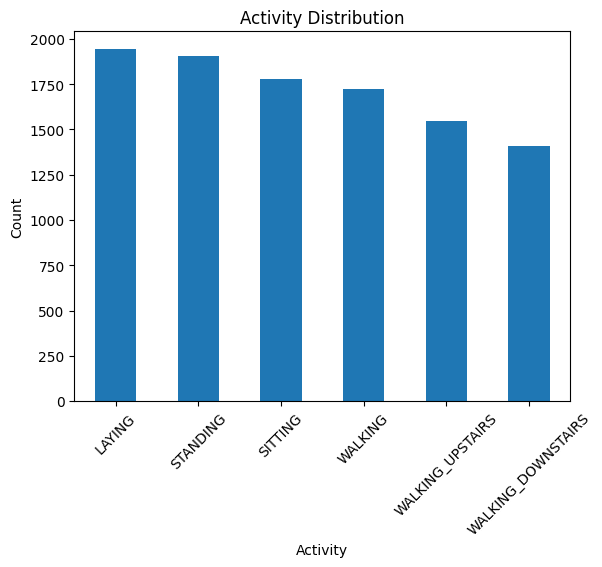

In [ ]:
# Plot the histogram for activity done by the participants
both_df['Activity'].value_counts().plot(kind='bar')
plt.title('Activity Distribution')
plt.xticks(rotation = 45)
plt.ylabel('Count')
plt.xlabel('Activity')
plt.show()


In [ ]:
# Plot the histogram for activity done per subject
import plotly.express as px
fig = px.histogram(both_df,x='subject',color='Activity')
fig.update_layout(scene = dict(
    xaxis_title="Subject",
    yaxis_title="Count"),
    title="Activities Perfomed by Subjects"
)

fig.show()

In [ ]:
# Creating a dataset that contain time domain data only
#time_df=both_df[['tBodyAcc-mean()-X','tBodyAcc-mean()-Y','tBodyAcc-mean()-Z','tGravityAcc-mean()-X','tGravityAcc-mean()-Y','tGravityAcc-mean()-Z','tBodyAccJerk-mean()-X','tBodyAccJerk-mean()-Y','tBodyAccJerk-mean()-Z','tBodyGyroJerk-mean()-X','tBodyGyroJerk-mean()-Y','tBodyGyroJerk-mean()-Z']]

In [ ]:
# Creating a dataset that contain freq domain data only
#freq_df=both_df[['tBodyAcc-mean()-X','tBodyAcc-mean()-Y','tBodyAcc-mean()-Z','tGravityAcc-mean()-X','tGravityAcc-mean()-Y','tGravityAcc-mean()-Z','tBodyAccJerk-mean()-X','tBodyAccJerk-mean()-Y','tBodyAccJerk-mean()-Z','tBodyGyroJerk-mean()-X','tBodyGyroJerk-mean()-Y','tBodyGyroJerk-mean()-Z']]

In [ ]:
both_df['Activity']

0                STANDING
1                STANDING
2                STANDING
3                STANDING
4                STANDING
               ...       
10294    WALKING_UPSTAIRS
10295    WALKING_UPSTAIRS
10296    WALKING_UPSTAIRS
10297    WALKING_UPSTAIRS
10298    WALKING_UPSTAIRS
Name: Activity, Length: 10299, dtype: object

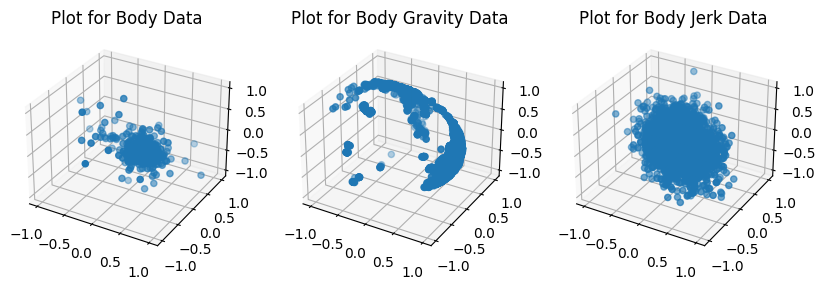

In [ ]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(131, projection='3d')
ax1.title.set_text('Plot for Body Data')
x = both_df['tBodyAcc-mean()-X']
y = both_df['tBodyAcc-mean()-Y']
z = both_df['tBodyAcc-mean()-Z']
ax1.scatter(x, y, z, cmap='plasma')

ax2 = fig.add_subplot(132, projection='3d')
ax2.title.set_text('Plot for Body Gravity Data')
x = both_df['tGravityAcc-mean()-X']
y = both_df['tGravityAcc-mean()-Y']
z = both_df['tGravityAcc-mean()-Z']
ax2.scatter(x, y, z, cmap=plt.hot())

ax3 = fig.add_subplot(133, projection='3d')
ax3.title.set_text('Plot for Body Jerk Data')
x = both_df['tBodyAccJerk-mean()-X']
y = both_df['tBodyAccJerk-mean()-Y']
z = both_df['tBodyAccJerk-mean()-Z']
ax3.scatter(x, y, z, cmap=plt.hot())

plt.show()

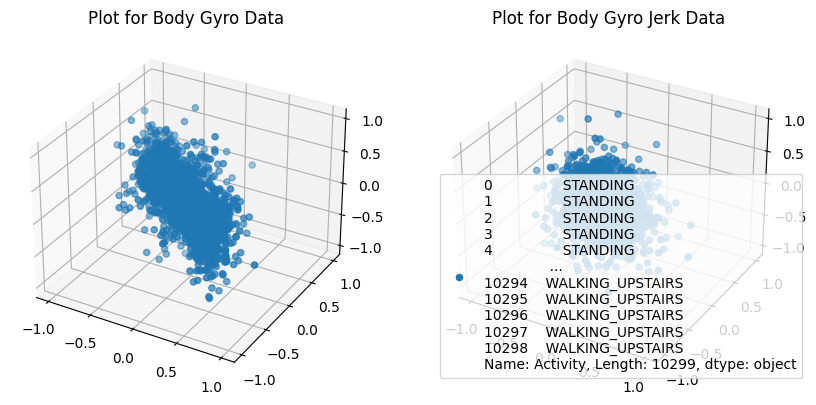

In [ ]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(121, projection='3d')
ax1.title.set_text('Plot for Body Gyro Data')
x = both_df['tBodyGyro-mean()-X']
y = both_df['tBodyGyro-mean()-Y']
z = both_df['tBodyGyro-mean()-Z']
ax1.scatter3D(x, y, z, cmap='plasma',label=both_df['Activity'])

ax3 = fig.add_subplot(122, projection='3d')
ax3.title.set_text('Plot for Body Gyro Jerk Data')
x = both_df['tBodyGyroJerk-mean()-X']
y = both_df['tBodyGyroJerk-mean()-Y']
z = both_df['tBodyGyroJerk-mean()-Z']
label=both_df['Activity']
ax3.scatter3D(x, y, z, cmap='plasma',label=both_df['Activity'])
ax3.legend()

plt.show()

In [ ]:
df_1=both_df[['tBodyGyroJerk-mean()-X','tBodyGyroJerk-mean()-Y','tBodyGyroJerk-mean()-Z','Activity']]
df_1=df_1.set_index('Activity')
df_1_sit=df_1.loc['SITTING']
df_1_sit.head()

tBodyGyroJerk-mean()-X  tBodyGyroJerk-mean()-Y  \
Activity                                                   
SITTING                -0.115714               -0.066663   
SITTING                -0.094242               -0.022414   
SITTING                -0.095291               -0.026020   
SITTING                -0.016521               -0.065024   
SITTING                -0.095522               -0.067817   

          tBodyGyroJerk-mean()-Z  
Activity                          
SITTING                 0.016336  
SITTING                -0.066971  
SITTING                -0.078194  
SITTING                -0.150639  
SITTING                -0.040523

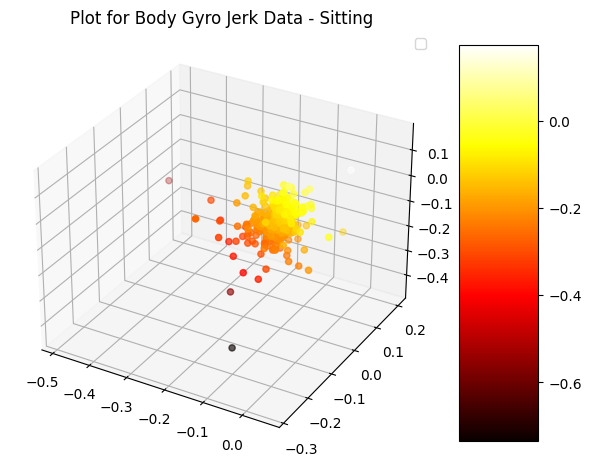

In [ ]:
fig = plt.figure(figsize=(15,15))

ax3 = fig.add_subplot(121, projection='3d')
ax3.title.set_text('Plot for Body Gyro Jerk Data - Sitting')
x = df_1_sit['tBodyGyroJerk-mean()-X']
y = df_1_sit['tBodyGyroJerk-mean()-Y']
z = df_1_sit['tBodyGyroJerk-mean()-Z']
sctt=ax3.scatter3D(x, y, z, c=(x+y+z))
fig.colorbar(sctt, ax = ax3, shrink = 0.5, aspect = 5)
ax3.legend()

plt.show()

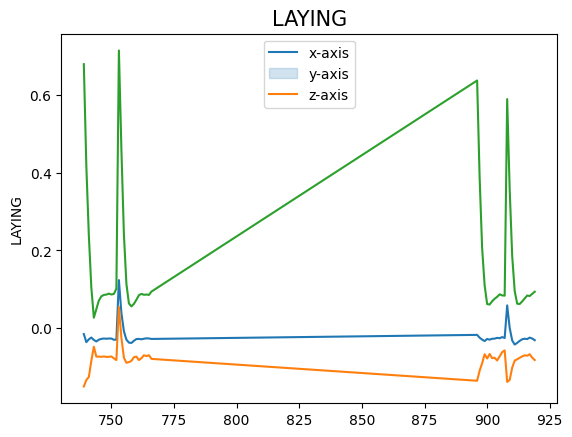

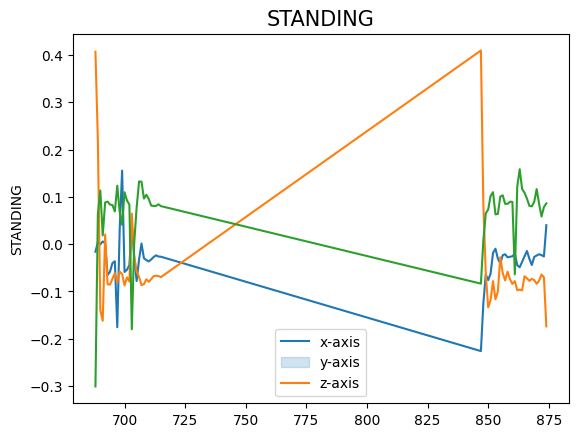

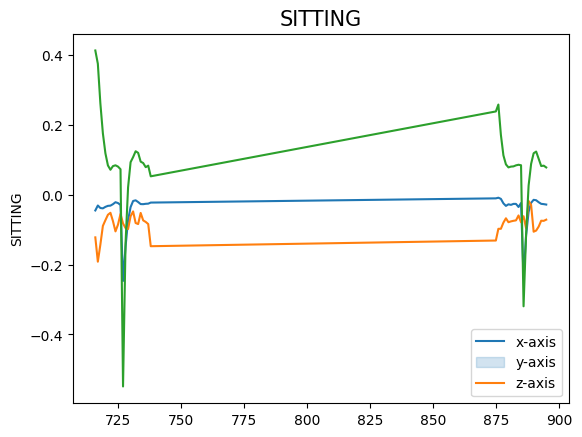

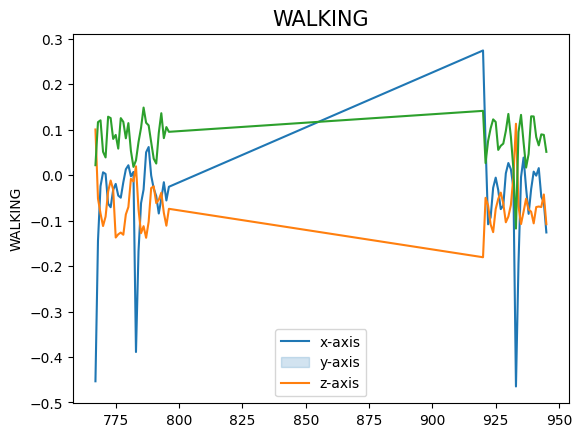

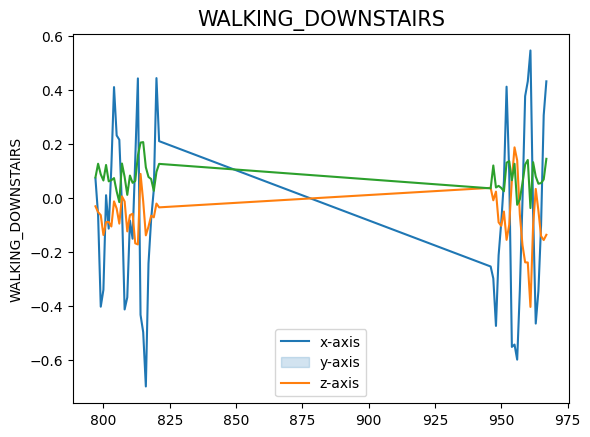

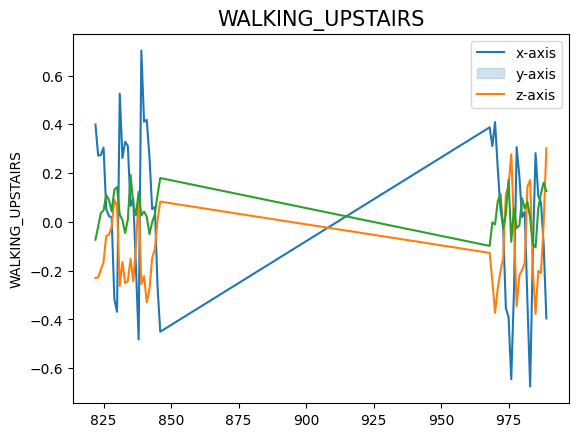

In [ ]:
activities = ['LAYING', 'STANDING', 'SITTING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
for i in activities:
    data3 = both_df[(both_df['subject'] == '#5') & (both_df['Activity'] == i)]
    sns.lineplot(y ='tBodyGyro-mean()-X', x=data3.index, data = data3)
    sns.lineplot(y ='tBodyGyro-mean()-Y', x=data3.index, data = data3)
    sns.lineplot(y ='tBodyGyro-mean()-Z', x=data3.index, data = data3)
    plt.legend(['x-axis', 'y-axis', 'z-axis'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

In [ ]:
data36 = both_df[(both_df['subject'] == '#3') & (both_df['Activity'] == i)]
data36.index

Int64Index([488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500,
            501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513,
            514, 515, 516, 517, 518, 519, 520, 521, 663, 664, 665, 666, 667,
            668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680,
            681, 682, 683, 684, 685, 686, 687],
           dtype='int64')

In [ ]:
both_df.isnull().sum()

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64

In [ ]:
both_df=both_df.dropna()

In [ ]:
both_df.shape

(10299, 563)

In [ ]:
X=both_df.drop(['subject','Activity'],axis=1)

In [ ]:
X.shape

(10299, 561)

In [ ]:
# Create a mapping of activity to a numeric value
dict_map = {'LAYING':1 , 'STANDING': 2, 'SITTING': 3, 'WALKING': 4, 'WALKING_DOWNSTAIRS': 5, 'WALKING_UPSTAIRS': 6}
y = both_df['Activity'].map(dict_map)

In [ ]:
# Split the data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Create a visualization function using TSNE to reduce the dimenionality to check for clustering
from sklearn.manifold import TSNE

def perform_tsne(x_train, y_train, perplexities, n_iter=1000):
    for index, per in enumerate (perplexities):
      X_reduced =TSNE(verbose=1, perplexity=per).fit_transform(x_train)
      df = pd.DataFrame({'x': X_reduced[:,0], 'y': X_reduced[:,1], 'label': y_train})
      print("Creating plot for TSNE visualization..")
      plt.figure(figsize=(7,7))
      sns.scatterplot(data=df, x='x', y='y', hue=y_train, palette="Set1")
      plt.title(f"Perplexity : {per} and max_iter: {n_iter}")
      plt.show()

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 7209 samples in 0.031s...
[t-SNE] Computed neighbors for 7209 samples in 3.476s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7209
[t-SNE] Computed conditional probabilities for sample 2000 / 7209
[t-SNE] Computed conditional probabilities for sample 3000 / 7209
[t-SNE] Computed conditional probabilities for sample 4000 / 7209
[t-SNE] Computed conditional probabilities for sample 5000 / 7209
[t-SNE] Computed conditional probabilities for sample 6000 / 7209
[t-SNE] Computed conditional probabilities for sample 7000 / 7209
[t-SNE] Computed conditional probabilities for sample 7209 / 7209
[t-SNE] Mean sigma: 0.584511
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.575668
[t-SNE] KL divergence after 1000 iterations: 1.631709
Creating plot for TSNE visualization..


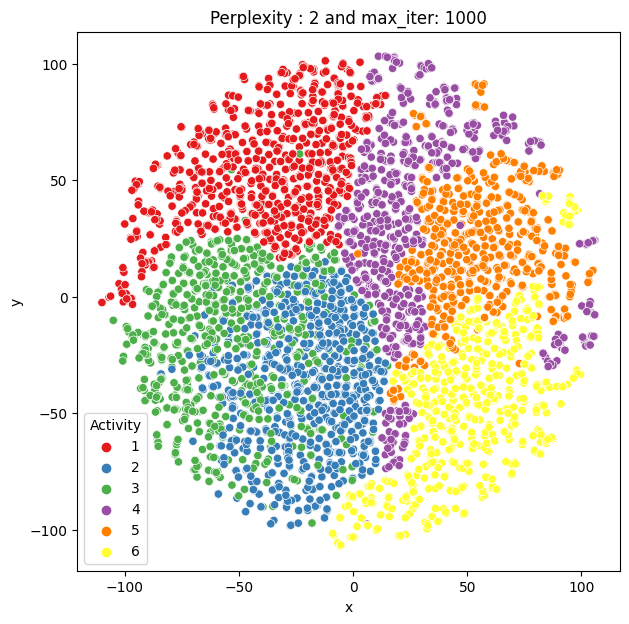

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 7209 samples in 0.022s...
[t-SNE] Computed neighbors for 7209 samples in 1.882s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7209
[t-SNE] Computed conditional probabilities for sample 2000 / 7209
[t-SNE] Computed conditional probabilities for sample 3000 / 7209
[t-SNE] Computed conditional probabilities for sample 4000 / 7209
[t-SNE] Computed conditional probabilities for sample 5000 / 7209
[t-SNE] Computed conditional probabilities for sample 6000 / 7209
[t-SNE] Computed conditional probabilities for sample 7000 / 7209
[t-SNE] Computed conditional probabilities for sample 7209 / 7209
[t-SNE] Mean sigma: 0.951680
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.491852
[t-SNE] KL divergence after 1000 iterations: 1.606995
Creating plot for TSNE visualization..


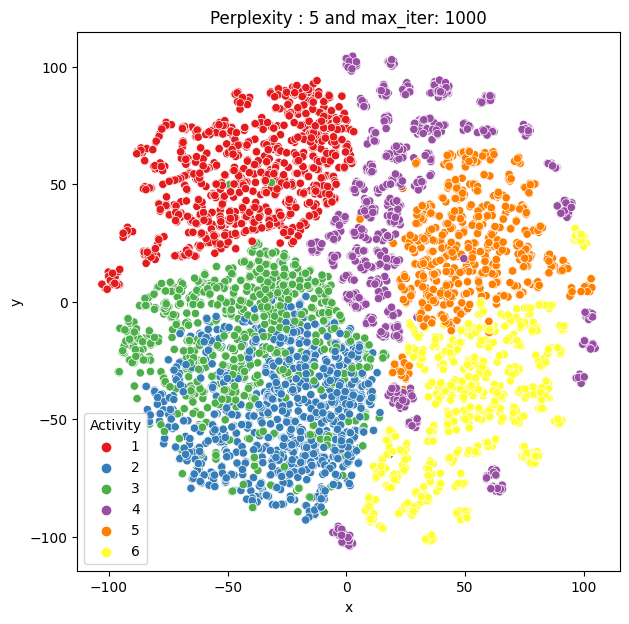

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7209 samples in 0.024s...
[t-SNE] Computed neighbors for 7209 samples in 2.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7209
[t-SNE] Computed conditional probabilities for sample 2000 / 7209
[t-SNE] Computed conditional probabilities for sample 3000 / 7209
[t-SNE] Computed conditional probabilities for sample 4000 / 7209
[t-SNE] Computed conditional probabilities for sample 5000 / 7209
[t-SNE] Computed conditional probabilities for sample 6000 / 7209
[t-SNE] Computed conditional probabilities for sample 7000 / 7209
[t-SNE] Computed conditional probabilities for sample 7209 / 7209
[t-SNE] Mean sigma: 1.124017
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.600662
[t-SNE] KL divergence after 1000 iterations: 1.568735
Creating plot for TSNE visualization..


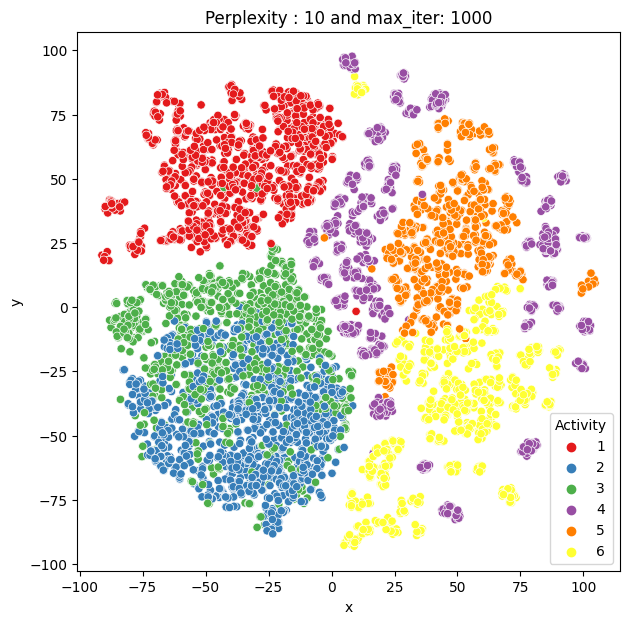

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7209 samples in 0.030s...
[t-SNE] Computed neighbors for 7209 samples in 2.000s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7209
[t-SNE] Computed conditional probabilities for sample 2000 / 7209
[t-SNE] Computed conditional probabilities for sample 3000 / 7209
[t-SNE] Computed conditional probabilities for sample 4000 / 7209
[t-SNE] Computed conditional probabilities for sample 5000 / 7209
[t-SNE] Computed conditional probabilities for sample 6000 / 7209
[t-SNE] Computed conditional probabilities for sample 7000 / 7209
[t-SNE] Computed conditional probabilities for sample 7209 / 7209
[t-SNE] Mean sigma: 1.261902
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.123322
[t-SNE] KL divergence after 1000 iterations: 1.506439
Creating plot for TSNE visualization..


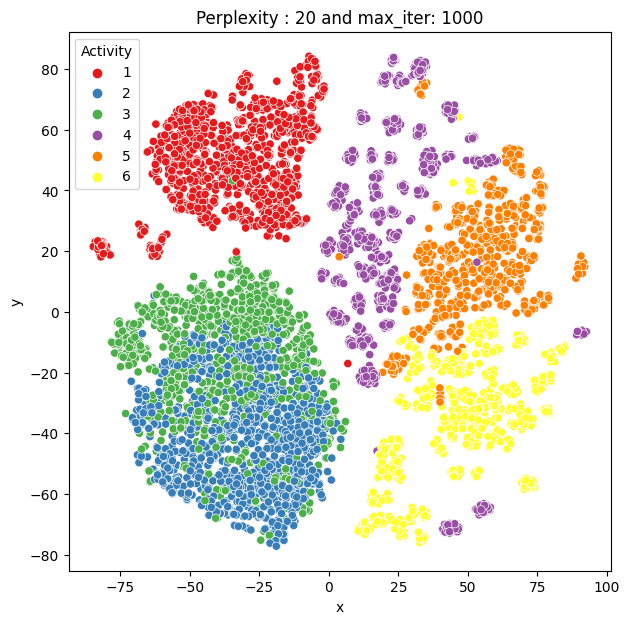

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7209 samples in 0.023s...
[t-SNE] Computed neighbors for 7209 samples in 2.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7209
[t-SNE] Computed conditional probabilities for sample 2000 / 7209
[t-SNE] Computed conditional probabilities for sample 3000 / 7209
[t-SNE] Computed conditional probabilities for sample 4000 / 7209
[t-SNE] Computed conditional probabilities for sample 5000 / 7209
[t-SNE] Computed conditional probabilities for sample 6000 / 7209
[t-SNE] Computed conditional probabilities for sample 7000 / 7209
[t-SNE] Computed conditional probabilities for sample 7209 / 7209
[t-SNE] Mean sigma: 1.419460
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.598091
[t-SNE] KL divergence after 1000 iterations: 1.381971
Creating plot for TSNE visualization..


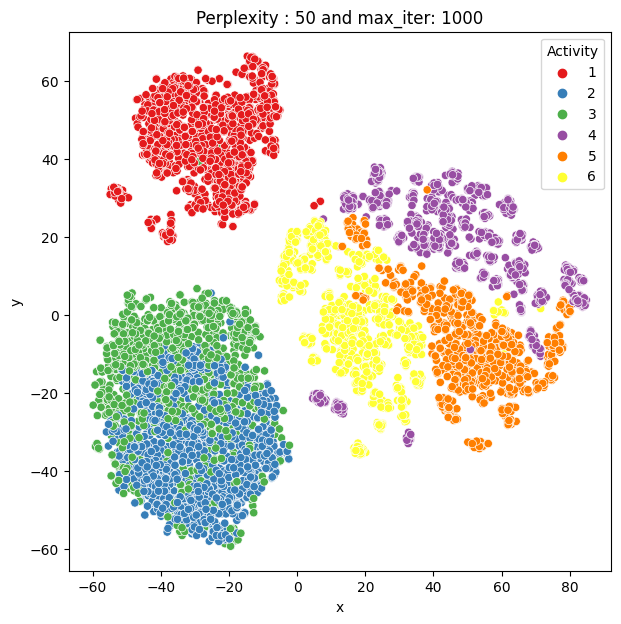

In [ ]:
perform_tsne(X_train, y_train, perplexities=[2, 5, 10, 20, 50])

In [ ]:
# Using PCA transform with PCA = 2

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

pca.score(X_test)

162.2634305054244

In [ ]:
# Plot PCA visualization with PCA = 2

import plotly.express as px
fig = px.scatter(X_train_pca,x=X_train_pca[:, 0], y=X_train_pca[:, 1],color=y_train)
fig.update_layout(scene = dict(
    xaxis_title="First PCA",
    yaxis_title="Second PCA"),
    title="PCA visualization of Sensor Dataset"
)

fig.show()

In [ ]:
# Using PCA transform with PCA = 3
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)

pca.score(X_test)

196.6297131722652

In [ ]:
# Plot PCA visualization with PCA = 3

import plotly.express as px
fig = px.scatter_3d(X_train_pca,x=X_train_pca[:, 0], y=X_train_pca[:, 1], z=X_train_pca[:, 2],color=y_train)
fig.update_layout(scene = dict(
    xaxis_title="First PCA",
    yaxis_title="Second PCA",
    zaxis_title="Third PCA"),
    title="PCA visualization of Sensor Dataset",
)

fig.show()

In [ ]:
# Create a series of box plot based on the columns passed into plot_box function

def plot_box(data, col):
  fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (20,15),tight_layout=True)
  index=0
  for i in range(2):
      for j in range(3):
          sns.boxplot(ax=axes[i, j], data=both_df, x='Activity', y=col.columns[index], showfliers=False, saturation=1)
          axes[i][j].tick_params(axis='x', rotation=45)
          axes[i][j].set_title(col.columns[index])
          index=index+1
  plt.show()


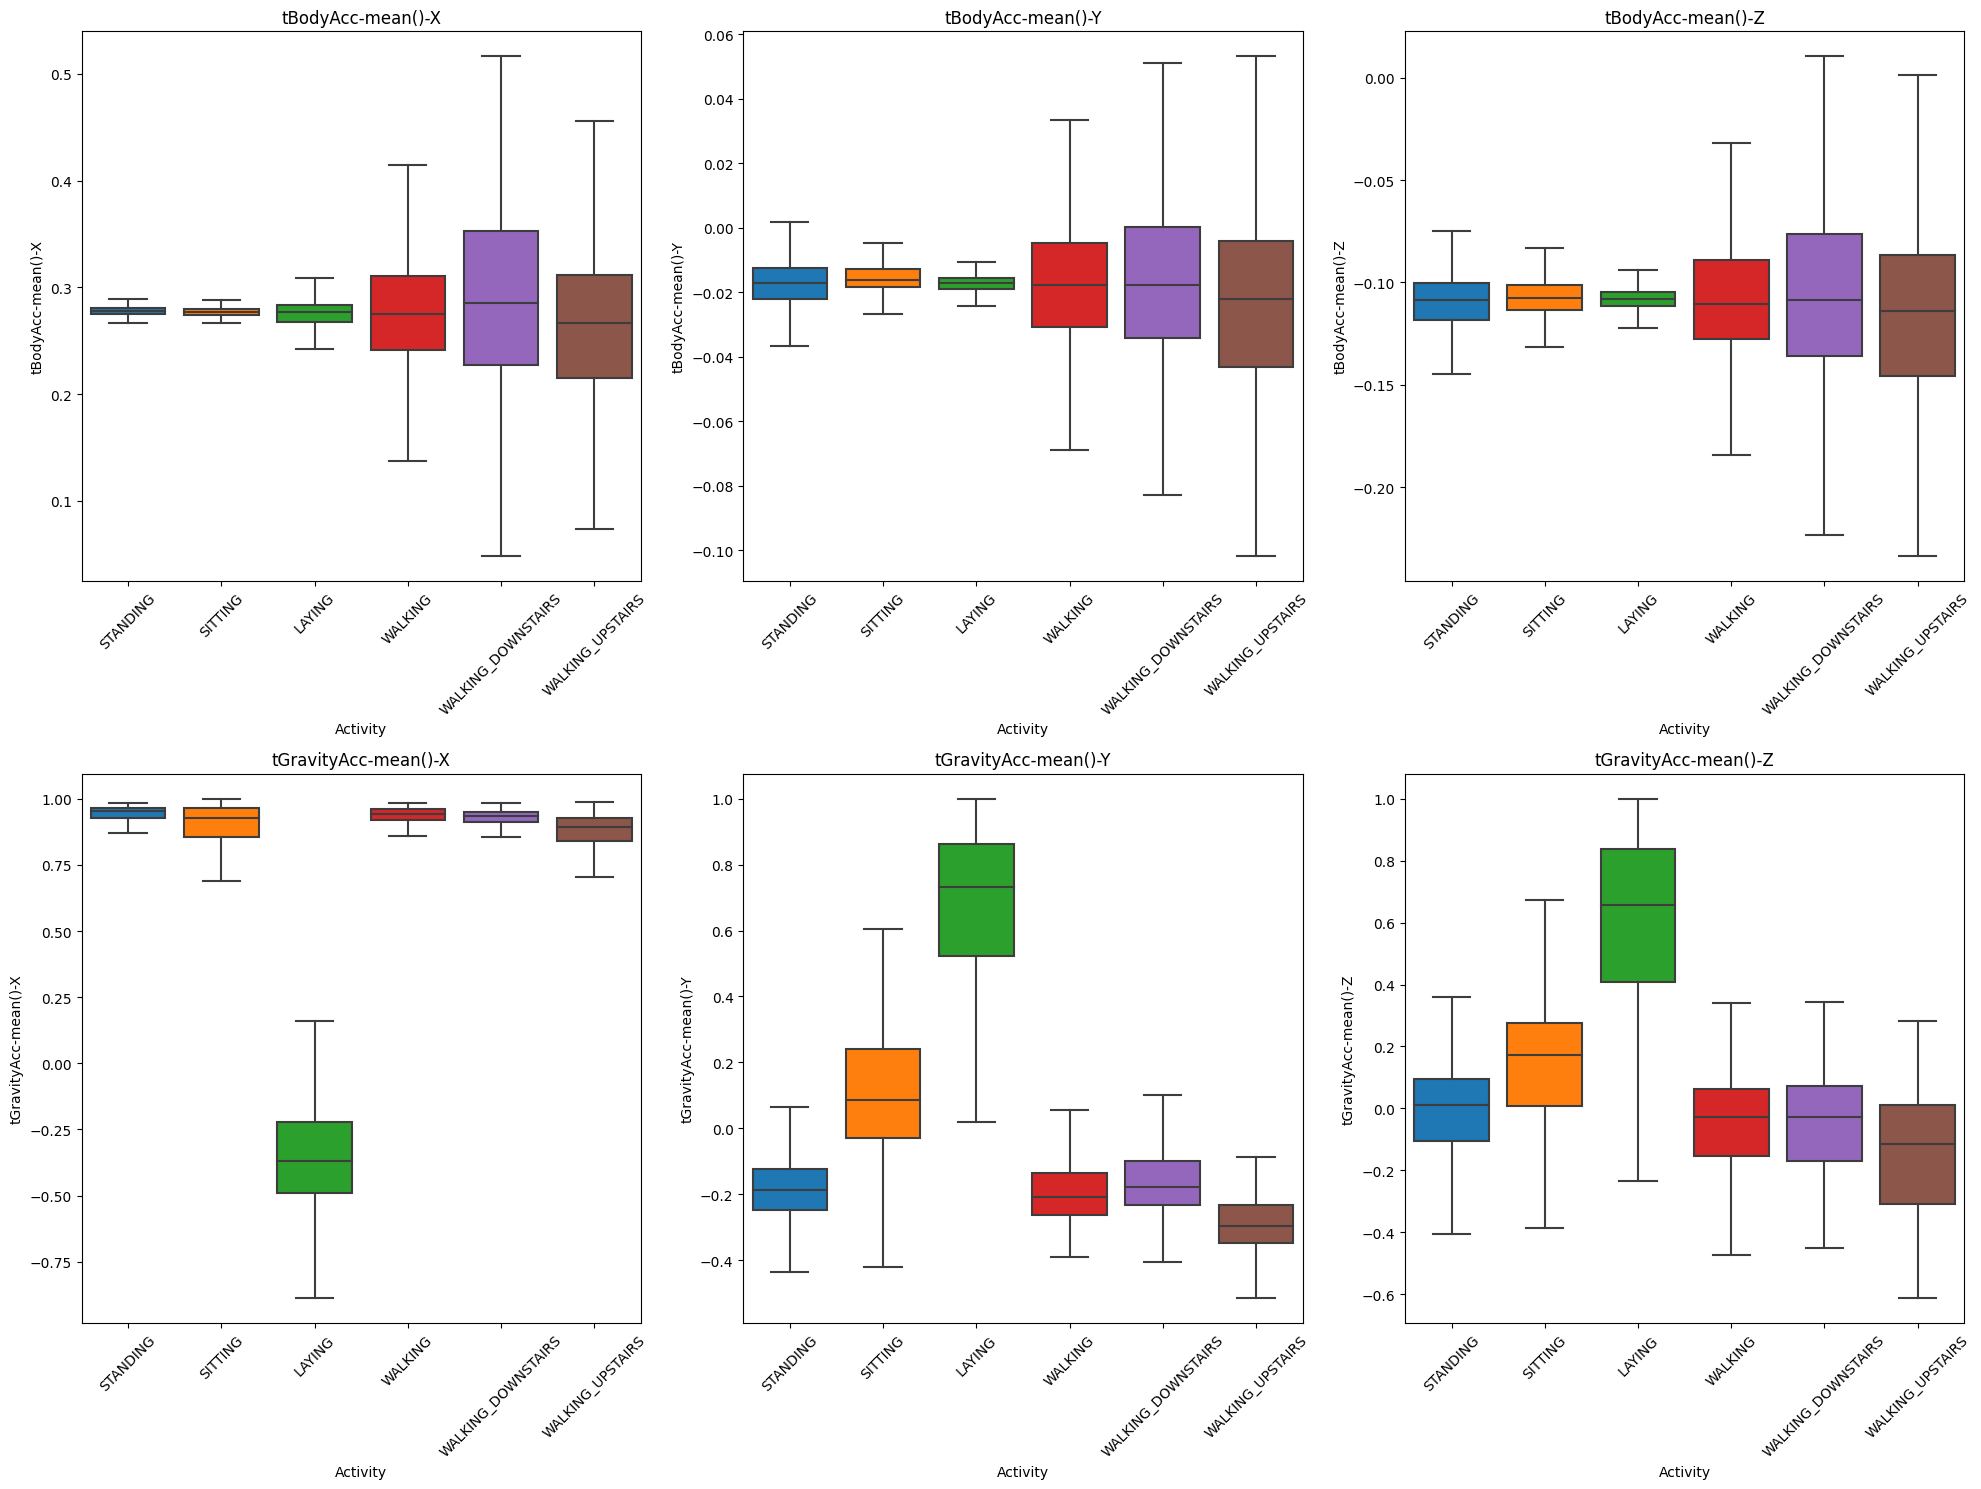

In [ ]:
# Examine the time domain data across accelorometer and gyroscope with boxplot in group of 6
cols = both_df.iloc[:,[0,1,2,40,41,42]]
plot_box(both_df, cols)

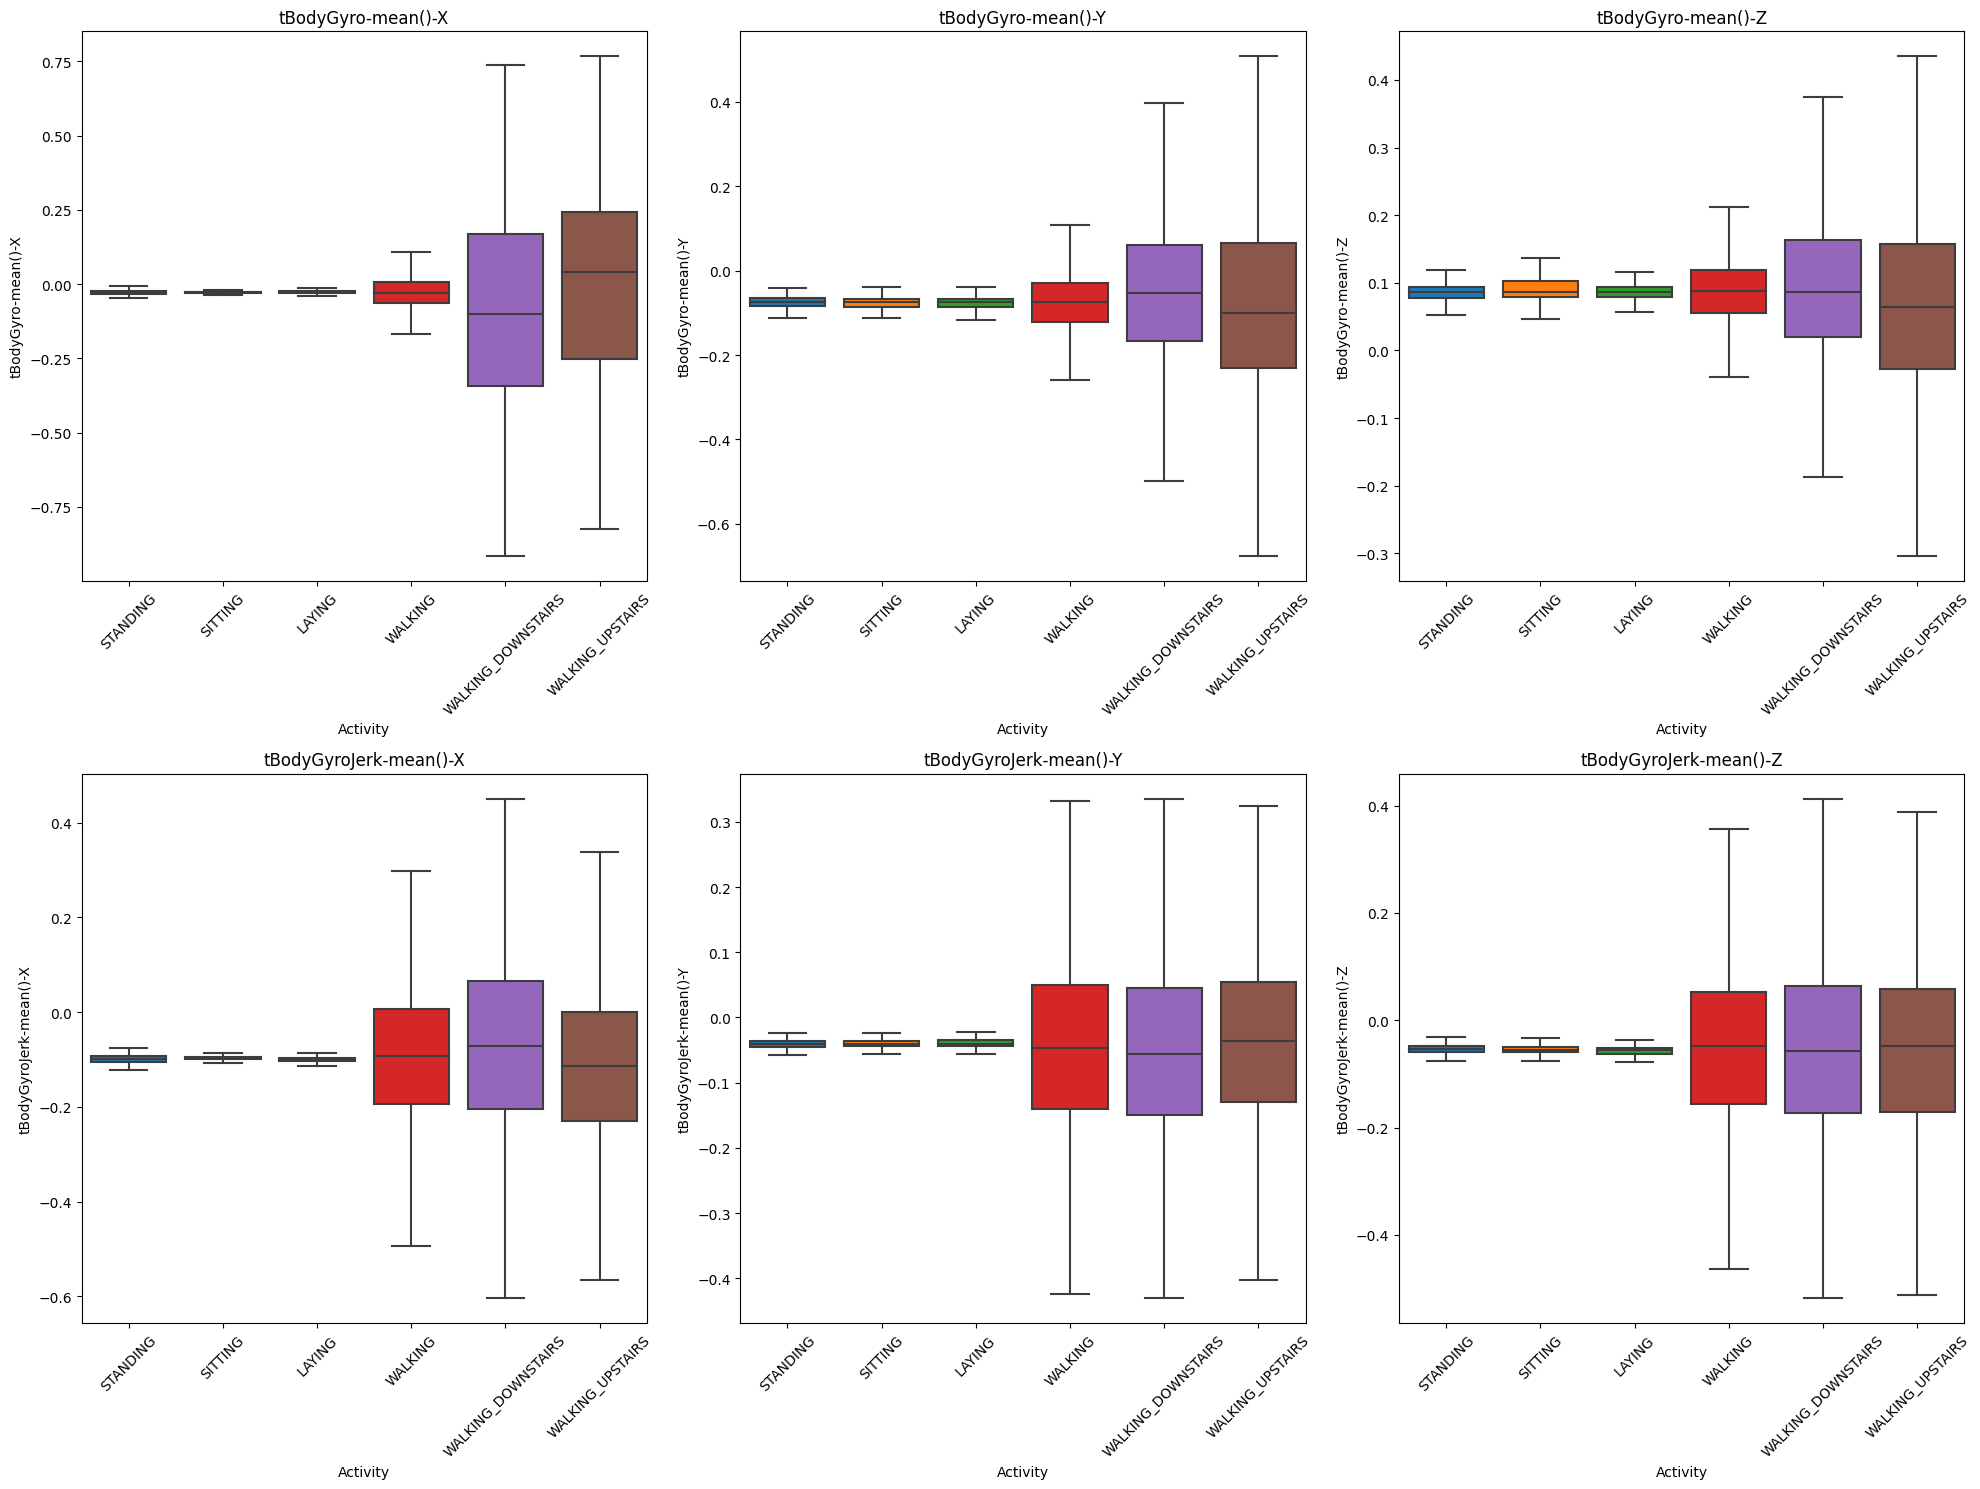

In [ ]:
# Examine the time domain data across accelorometer and gyroscope with boxplot in group of 6
cols = both_df.iloc[:,[120,121,122,160,161,162]]
plot_box(both_df, cols)

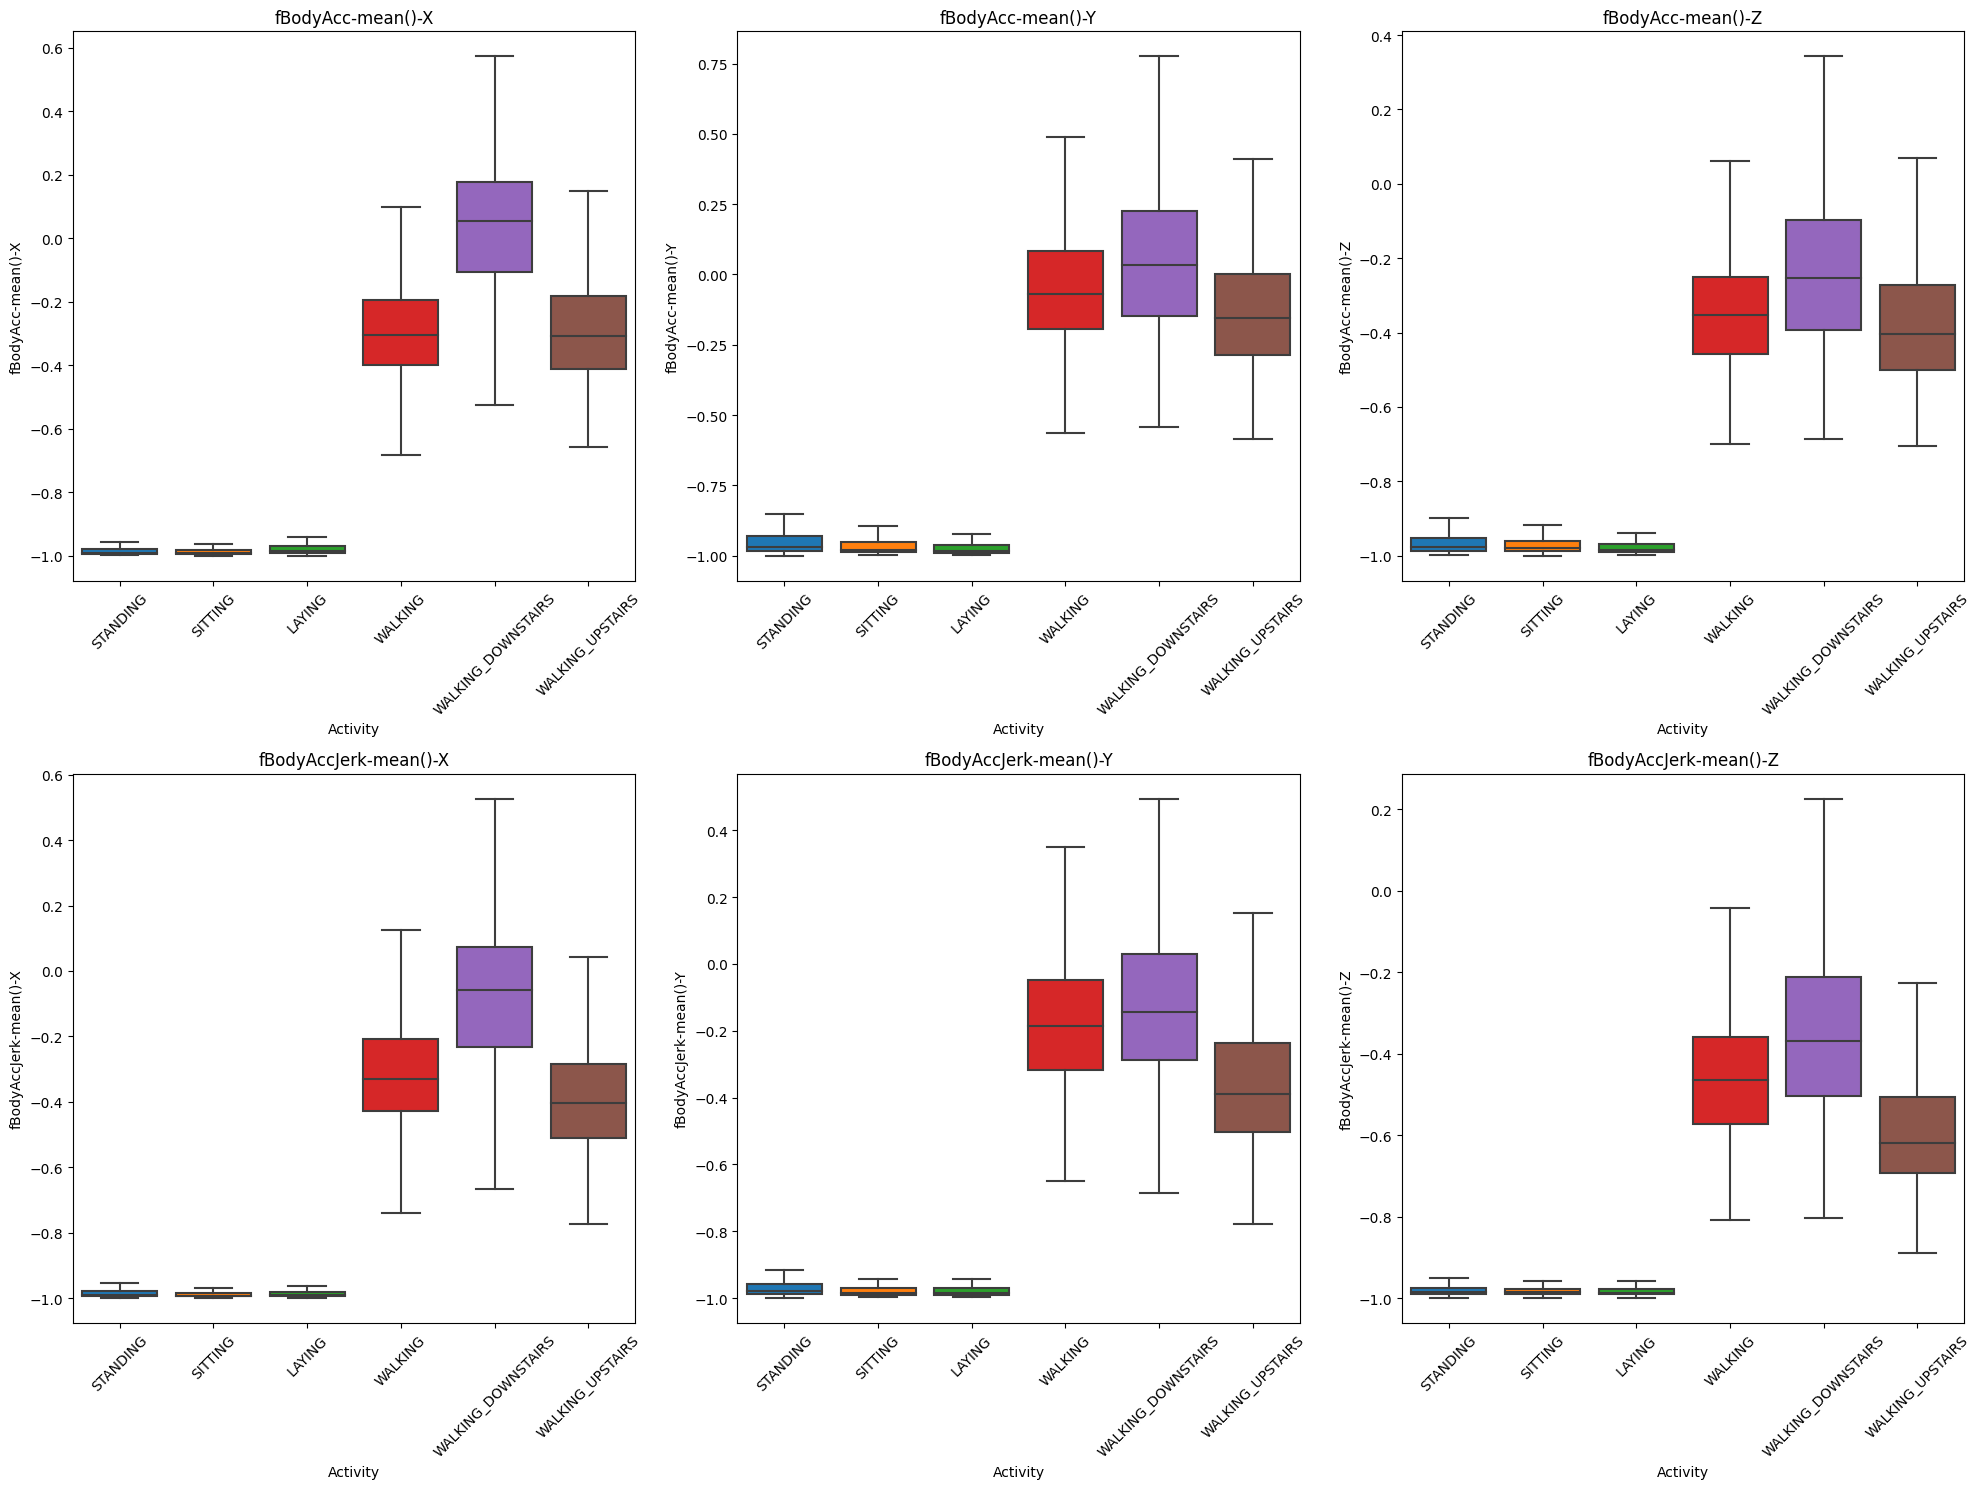

In [ ]:
# Examine the time domain data across accelorometer and gyroscope with boxplot in group of 6
cols = both_df.iloc[:,[265,266,267,344,345,346]]
plot_box(both_df, cols)

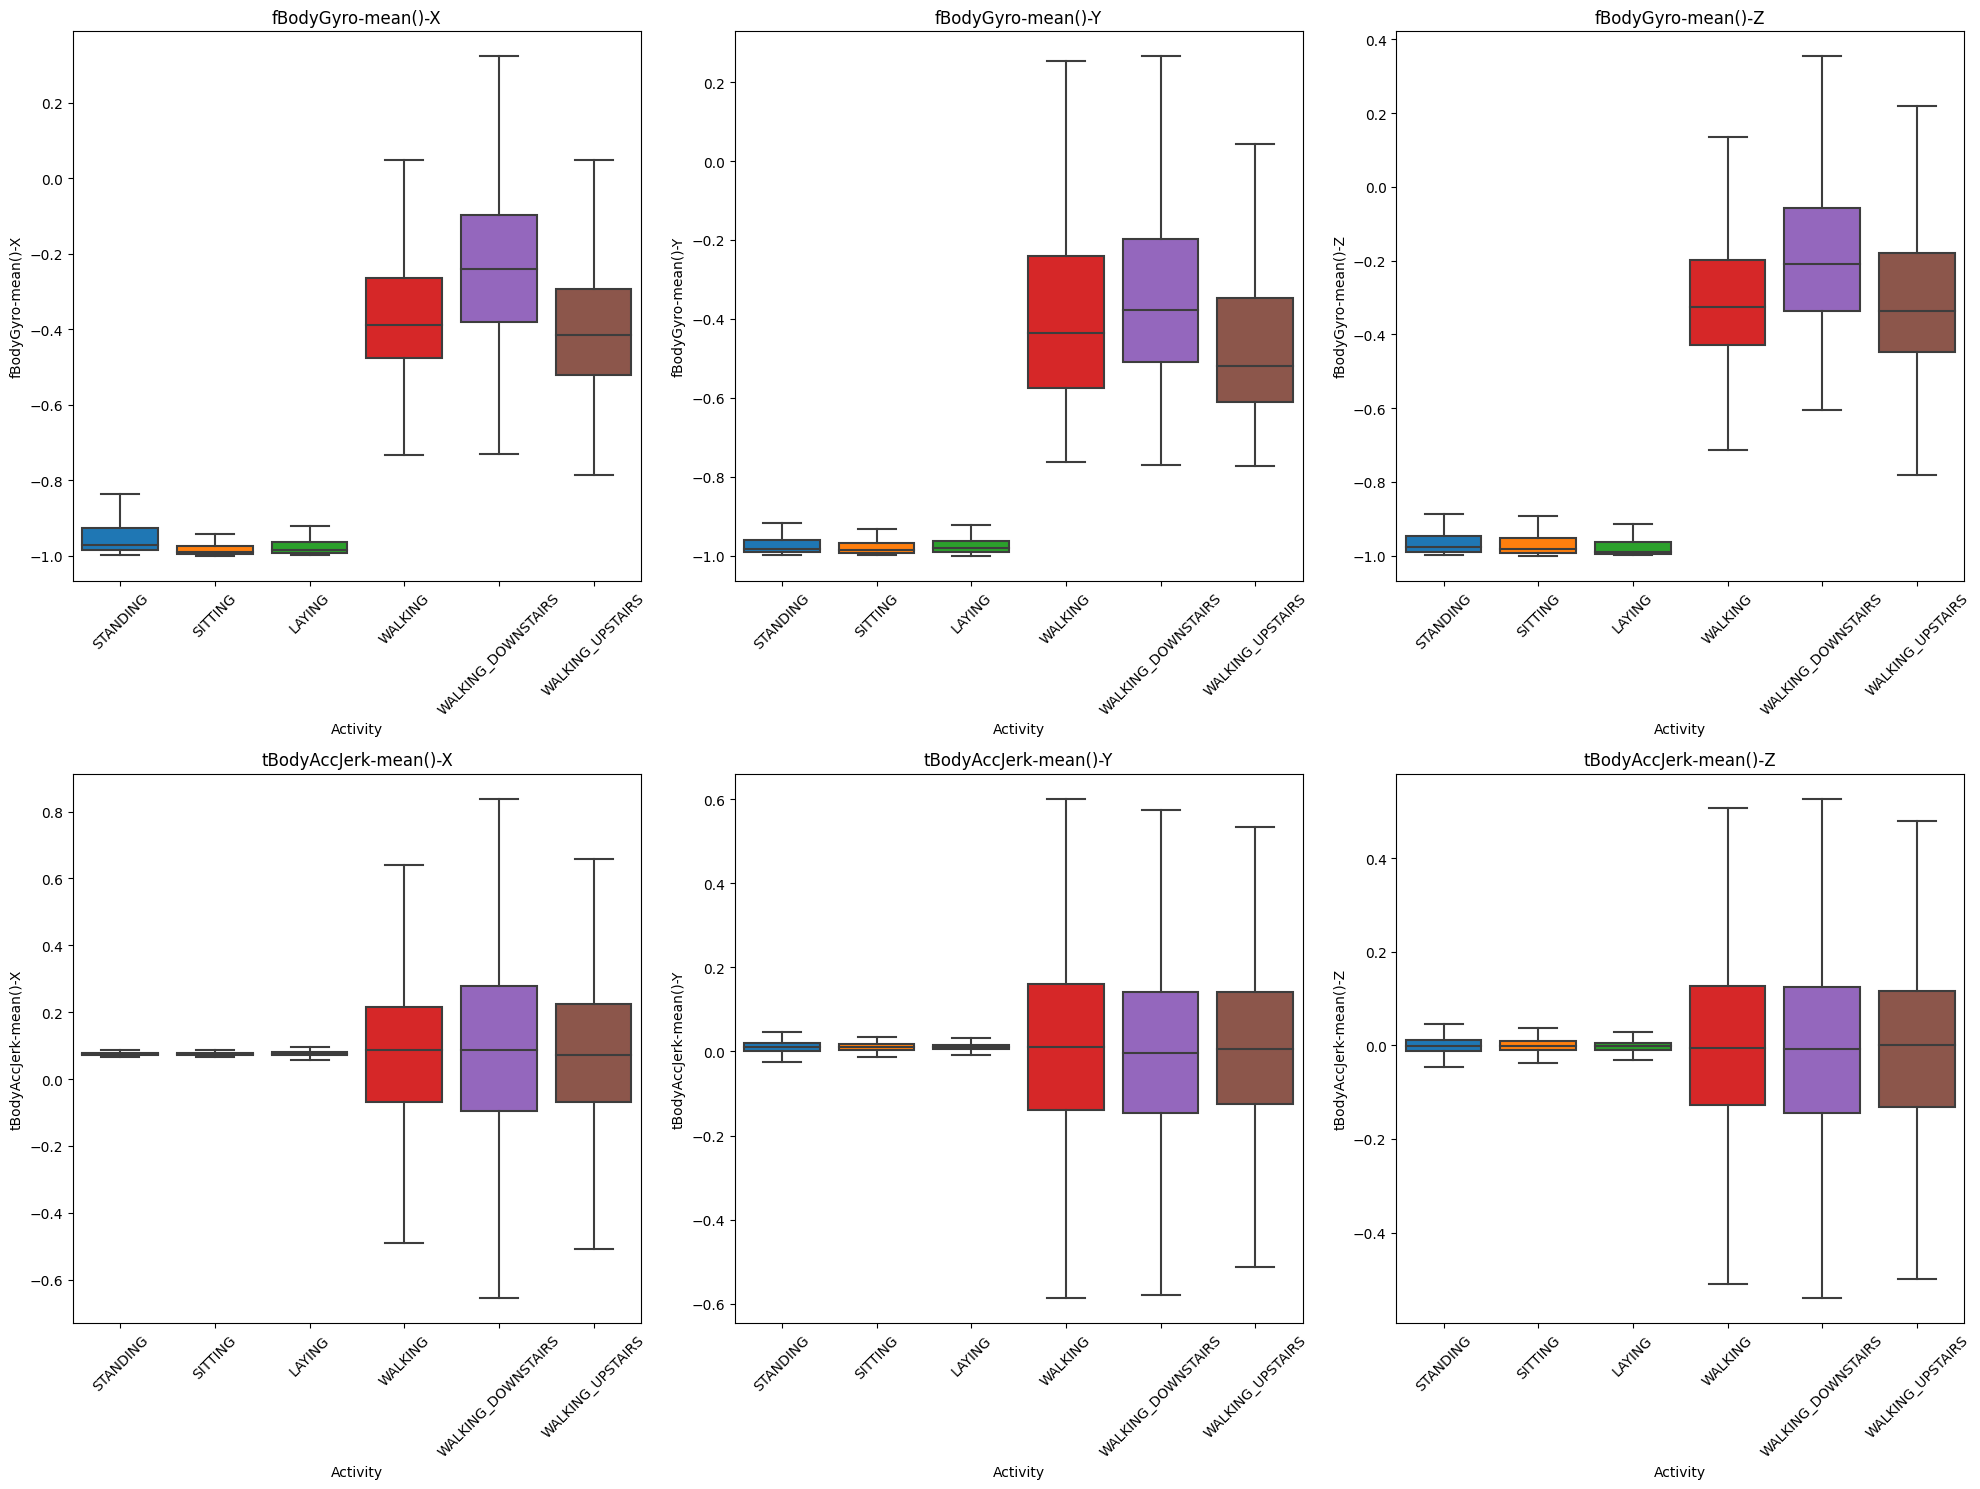

In [ ]:
# Examine the time domain data across accelorometer and gyroscope with boxplot in group of 6
cols = both_df.iloc[:,[423,424,425,80,81,82]]
plot_box(both_df, cols)

In [ ]:
# export dataset with index to csv for reference
s = pd.Series(both_df.columns)
s.to_csv(r'../content/dataindex.csv', index=False, header=False)
print(s)

0         tBodyAcc-mean()-X
1         tBodyAcc-mean()-Y
2         tBodyAcc-mean()-Z
3          tBodyAcc-std()-X
4          tBodyAcc-std()-Y
               ...         
558    angle(X,gravityMean)
559    angle(Y,gravityMean)
560    angle(Z,gravityMean)
561                 subject
562                Activity
Length: 563, dtype: object


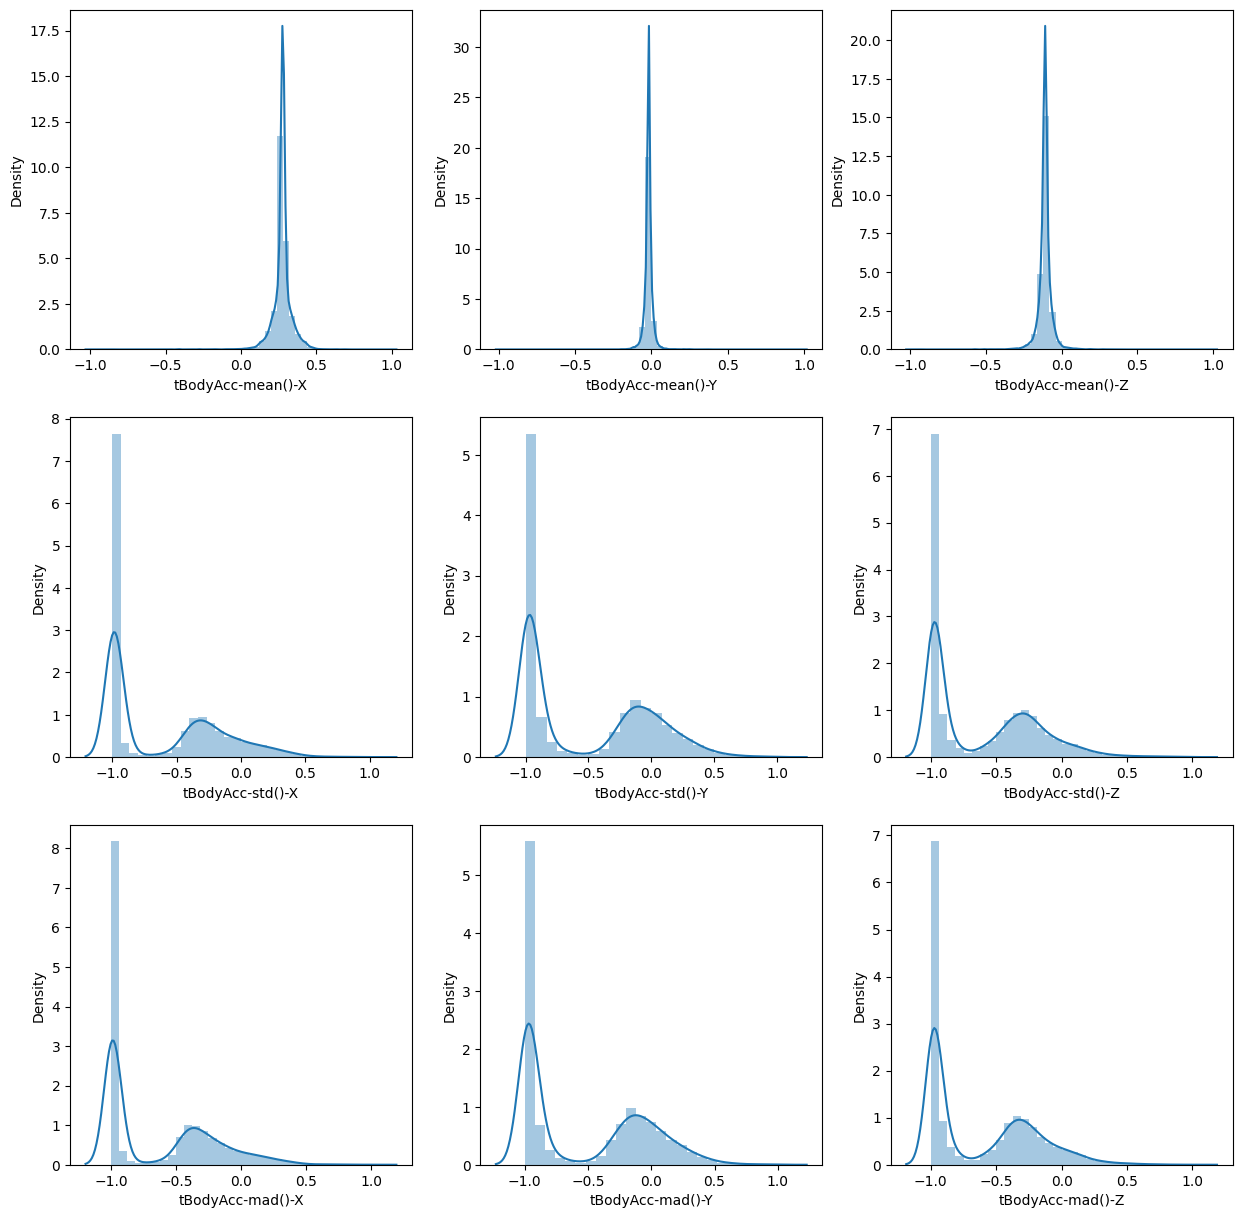

In [ ]:
# Examine the time domain data across as distribution plot in group of 6
def plot_distribution(data, col):
    fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (15, 15))
    for i, ax in zip(range(9), axes.flat):
        sns.distplot(both_df[cols[i]], ax = ax)
    plt.show()

# Select body acceleration attributes for  time series data of X, Y, Z axis data
cols = both_df.columns[:9]
plot_distribution(both_df, cols)

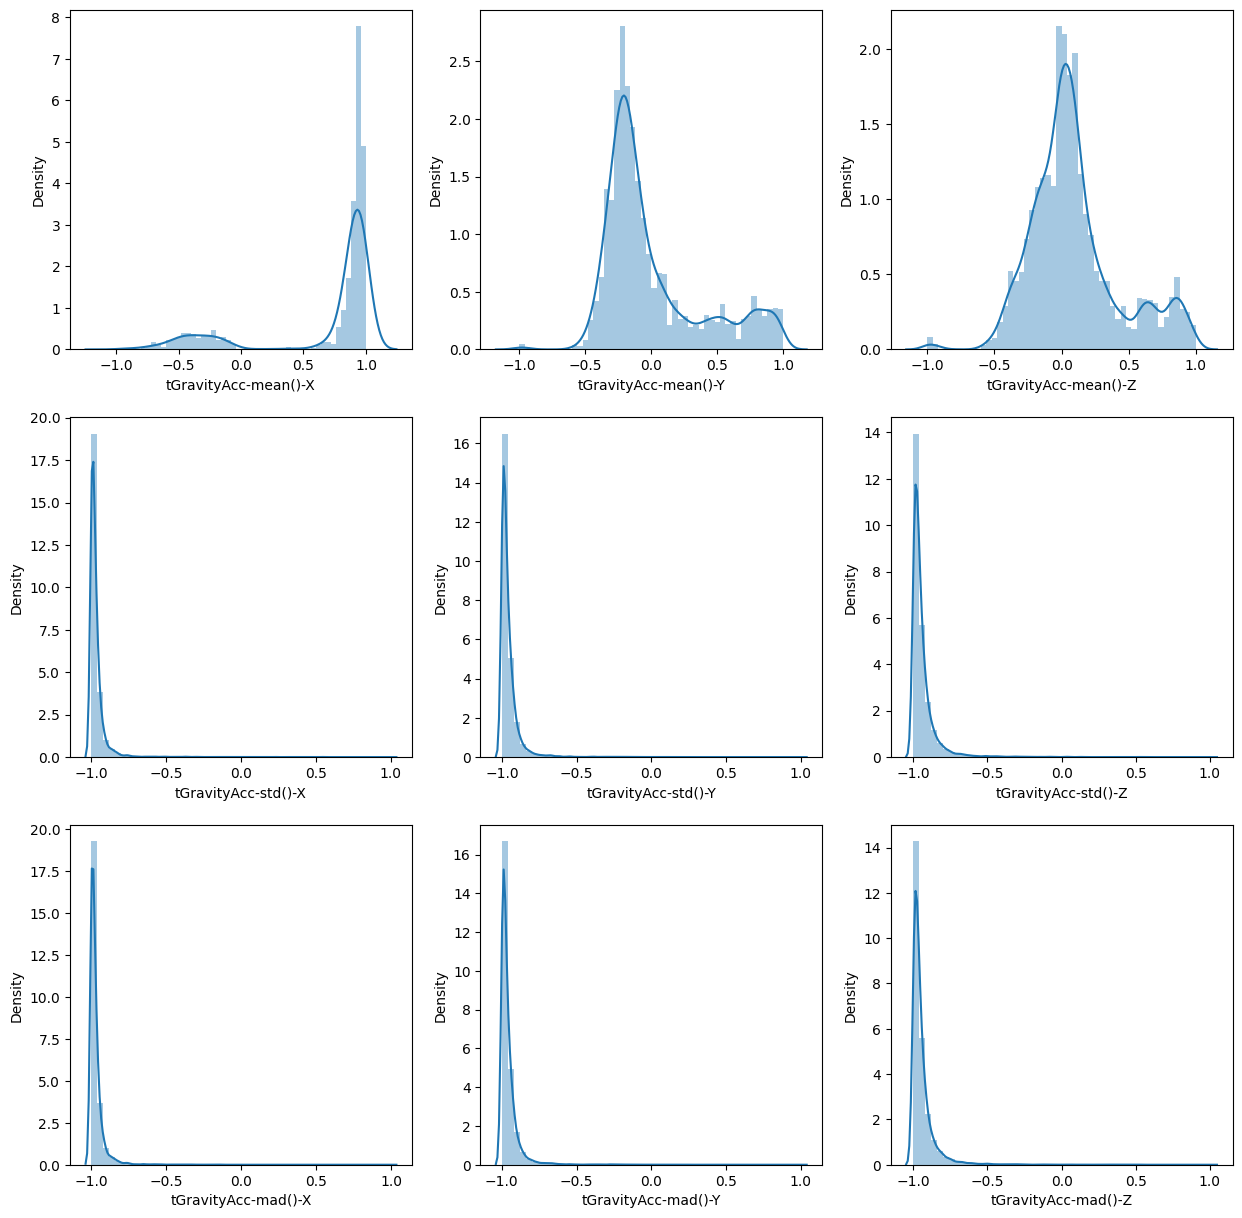

In [ ]:

# Select gravity body acceleration attributes for  time series data of X, Y, Z axis
cols = both_df.columns[40:49]
plot_distribution(both_df, cols)

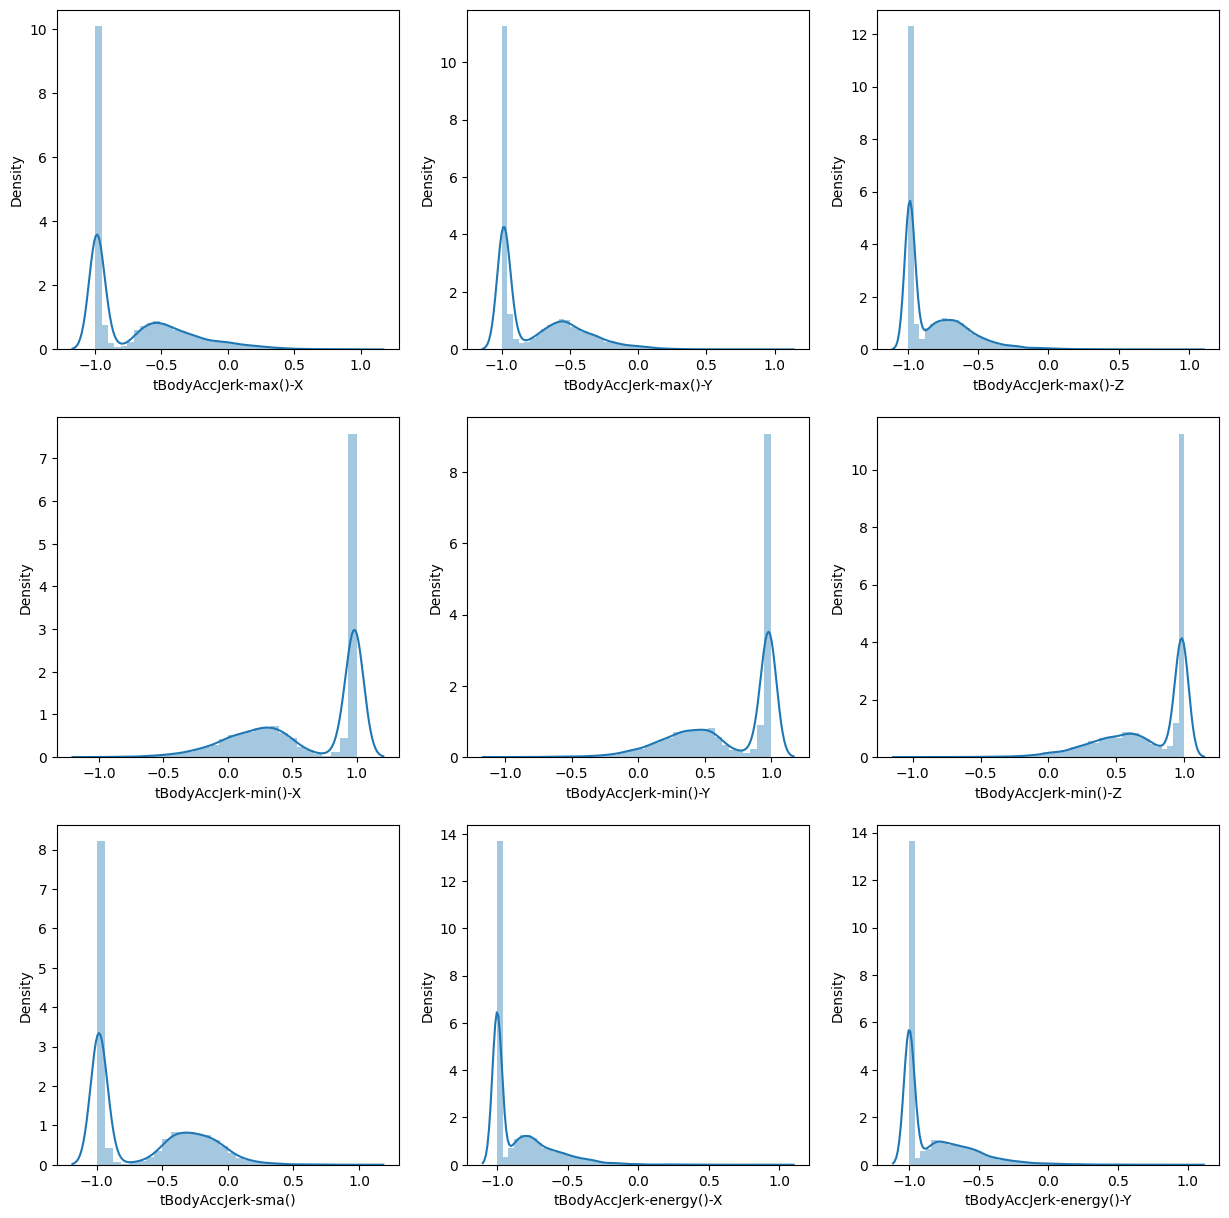

In [ ]:
 # Select jerk body acceleration attributes for  time series data of X, Y, Z axis
cols = both_df.columns[89:98]
plot_distribution(both_df, cols)

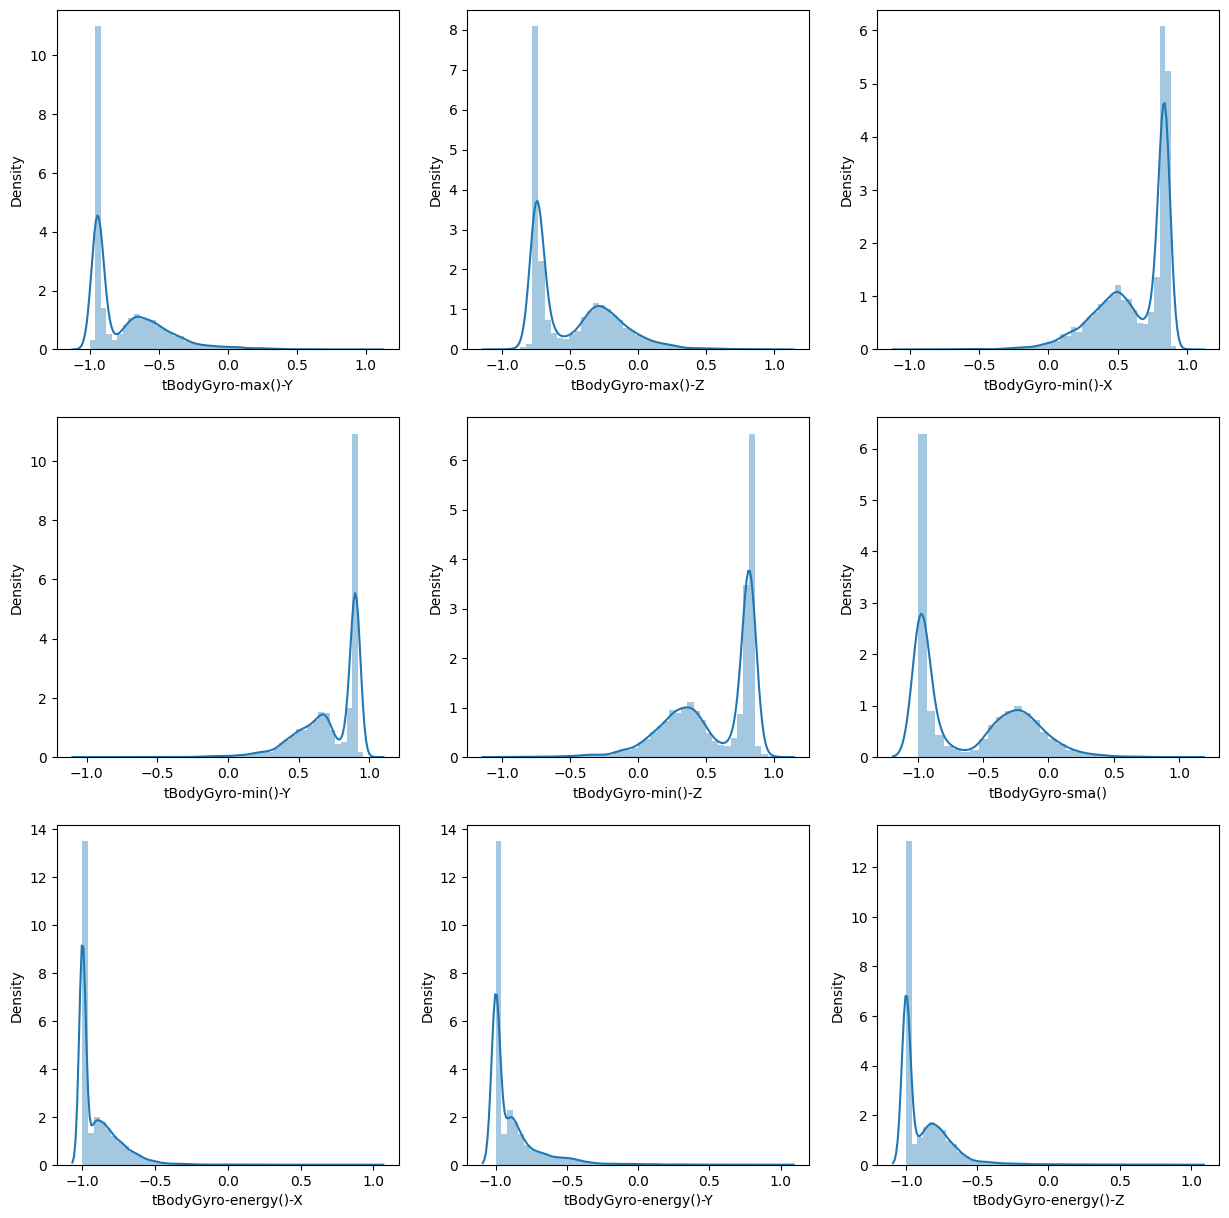

In [ ]:
# Select gyro body attributes for time series data of X, Y, Z axis
cols = both_df.columns[130:139]
plot_distribution(both_df, cols)

Section 2 Data Modeling: Machine Learning
---
---



In [ ]:
#Create pipeline for Logistric Regression model
log_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression())
    ]
)
log_pipe

Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

In [ ]:
param_grid = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__multi_class' : ['multinomial'],
    'logreg__solver': ['newton-cg', 'saga','sag']
}

grid = GridSearchCV(log_pipe, param_grid, cv=5)

# record start time
start = time.process_time()

grid_log = grid.fit(X_train, y_train)

# record end time
end = time.process_time()


print('Parameters')
print(grid_log.best_params_)
print('')
print('Best Testing Score')
print(grid_log.best_score_)
print('')
print('Best Training Score')
print(grid_log.score(X_train,y_train))
print('')
print('Best Estimator')
print(grid_log.best_estimator_)
print('')
print('Avg Fit Time using mean_fit_time() from CV_results_')
print(grid_log.cv_results_['mean_fit_time'].mean())
print('')
print('Total Elapsed Fit Time using time.process_time()')
etime_log=(end - start)
print(etime_log, " seconds")
print('')
print('Classification Report')
y_pred = grid_log.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
print('')
# Calculate precision, recall, and f1-score for each class
precision_log = precision_score(y_test, y_pred, average='weighted')
recall_log = recall_score(y_test, y_pred,average='weighted')
f1_log = f1_score(y_test, y_pred,average='weighted')

# Print the results
print(f"Precision: {precision_log:.2f}")
print(f"Recall: {recall_log:.2f}")
print(f"F1-score: {f1_log:.2f}")


Parameters
{'logreg__C': 1, 'logreg__multi_class': 'multinomial', 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}

Best Testing Score
0.9825218655945699

Best Training Score
0.9965321126369816

Best Estimator
Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=1, multi_class='multinomial',
                                    solver='newton-cg'))])

Avg Fit Time using mean_fit_time() from CV_results_
12.902909290790555

Total Elapsed Fit Time using time.process_time()
1899.63737887  seconds

Classification Report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       597
           2       0.95      0.97      0.96       547
           3       0.97      0.94      0.95       563
           4       1.00      1.00      1.00       539
           5       1.00      0.99      1.00       420
           6       0.99      1.00      0.99       424

    accuracy                       

In [ ]:
#Create pipeline for Guassian NB model
gnb_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('gnb', GaussianNB())
    ]
)
gnb_pipe

Pipeline(steps=[('scaler', StandardScaler()), ('gnb', GaussianNB())])

In [ ]:
param_grid = {
        'gnb__priors': [None],
        'gnb__var_smoothing' : [0.00000001, 0.000000001, 0.0000001]
}

grid = GridSearchCV(gnb_pipe, param_grid, cv=5)

# record start time
start = time.process_time()

grid_gnb = grid.fit(X_train, y_train)

# record end time
end = time.process_time()

print('Parameters')
print(grid_gnb.best_params_)
print('')
print('Best Testing Score')
print(grid_gnb.best_score_)
print('')
print('Best Training Score')
print(grid_gnb.score(X_train,y_train))
print('')
print('Best Estimator')
print(grid_gnb.best_estimator_)
print('')
print('Avg Fit Time using mean_fit_time() from CV_results_')
print(grid_gnb.cv_results_['mean_fit_time'].mean())
print('')
print('Total Elapsed Fit Time using time.process_time()')
# print elapsed time in ms
etime_gnb=(end - start)
print(etime_gnb, " seconds")
print('')
print('Classification Report')
y_pred = grid_gnb.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
print('')
# Calculate precision, recall, and f1-score for each class
precision_gnb = precision_score(y_test, y_pred, average='weighted')
recall_gnb = recall_score(y_test, y_pred,average='weighted')
f1_gnb = f1_score(y_test, y_pred,average='weighted')

# Print the results
print(f"Precision: {precision_gnb:.2f}")
print(f"Recall: {recall_gnb:.2f}")
print(f"F1-score: {f1_gnb:.2f}")

Parameters
{'gnb__priors': None, 'gnb__var_smoothing': 1e-07}

Best Testing Score
0.6509840119119005

Best Training Score
0.6576501595228187

Best Estimator
Pipeline(steps=[('scaler', StandardScaler()),
                ('gnb', GaussianNB(var_smoothing=1e-07))])

Avg Fit Time using mean_fit_time() from CV_results_
0.24822138150533038

Total Elapsed Fit Time using time.process_time()
3.0257177479998063  seconds

Classification Report
              precision    recall  f1-score   support

           1       0.98      0.55      0.71       597
           2       0.81      0.23      0.36       547
           3       0.43      0.91      0.59       563
           4       0.92      0.73      0.81       539
           5       0.78      0.77      0.78       420
           6       0.68      0.91      0.78       424

    accuracy                           0.67      3090
   macro avg       0.77      0.68      0.67      3090
weighted avg       0.77      0.67      0.66      3090


Precision: 0.77
Reca

In [ ]:
#Create pipeline for KNN model
knn_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ]
)
knn_pipe

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [ ]:
k_range = list(range(1,21,2))
leaf_range = list(range(1,21,2))
param_grid = {
    'knn__n_neighbors' : k_range,
    'knn__leaf_size' : leaf_range,
    'knn__weights' : ['uniform', 'distance']
}

grid = GridSearchCV(knn_pipe, param_grid)

# record start time
start = time.process_time()

grid_knn = grid.fit(X_train, y_train)

# record end time
end = time.process_time()

print('Parameters')
print(grid_knn.best_params_)
print('')
print('Best Testing Score')
print(grid_knn.best_score_)
print('')
print('Best Training Score')
print(grid_knn.score(X_train,y_train))
print('')
print('Best Estimator')
print(grid_knn.best_estimator_)
print('')
print('Avg Fit Time using mean_fit_time() from CV_results_')
print(grid_knn.cv_results_['mean_fit_time'].mean())
print('')
print('Total Elapsed Fit Time using time.process_time()')
# print elapsed time in ms
etime_knn=(end - start)
print(etime_knn, " seconds")
print('')
print('Classification Report')
y_pred = grid_knn.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
print('')
# Calculate precision, recall, and f1-score for each class
precision_knn = precision_score(y_test, y_pred, average='weighted')
recall_knn = recall_score(y_test, y_pred,average='weighted')
f1_knn = f1_score(y_test, y_pred,average='weighted')

# Print the results
print(f"Precision: {precision_knn:.2f}")
print(f"Recall: {recall_knn:.2f}")
print(f"F1-score: {f1_knn:.2f}")


Parameters
{'knn__leaf_size': 1, 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}

Best Testing Score
0.9560262608509849

Best Training Score
1.0

Best Estimator
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(leaf_size=1, n_neighbors=1))])

Avg Fit Time using mean_fit_time() from CV_results_
0.08802638125419618

Total Elapsed Fit Time using time.process_time()
772.71156479  seconds

Classification Report
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       597
           2       0.89      0.93      0.91       547
           3       0.93      0.88      0.90       563
           4       0.99      0.99      0.99       539
           5       0.99      0.98      0.99       420
           6       0.99      1.00      0.99       424

    accuracy                           0.96      3090
   macro avg       0.96      0.96      0.96      3090
weighted avg       0.96      0.96      0.96      3090


Pre

In [ ]:
#Create pipeline for SVC model
svm_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True))
    ]
)
svm_pipe

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(probability=True))])

In [ ]:
param_grid = {
              'svm__C': [0.1, 1, 10, 100, 1000],
              'svm__gamma': [1, 0.1, 0.01, 0.001],
              'svm__kernel': ['rbf']
              }

grid = GridSearchCV(svm_pipe, param_grid)

# record start time
start = time.process_time()

grid_svm = grid.fit(X_train, y_train)

# record end time
end = time.process_time()

print('Parameters')
print(grid_svm.best_params_)
print('')
print('Best Testing Score')
print(grid_svm.best_score_)
print('')
print('Best Training Score')
print(grid_svm.score(X_train,y_train))
print('')
print('Best Estimator')
print(grid_svm.best_estimator_)
print('')
print('Avg Fit Time using mean_fit_time() from CV_results_')
print(grid_svm.cv_results_['mean_fit_time'].mean())
print('')
print('Total Elapsed Fit Time using time.process_time()')
# print elapsed time in ms
etime_svm=(end - start)
print(etime_svm, " seconds")
print('')
print('Classification Report')
y_pred = grid_svm.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
print('')
# Calculate precision, recall, and f1-score for each class.
# Weighted option is selected for calculating the score for each label
precision_svm = precision_score(y_test, y_pred, average='weighted')
recall_svm = recall_score(y_test, y_pred,average='weighted')
f1_svm = f1_score(y_test, y_pred,average='weighted')

# Print the results
print(f"Precision: {precision_svm:.2f}")
print(f"Recall: {recall_svm:.2f}")
print(f"F1-score: {f1_svm:.2f}")


KeyboardInterrupt: ignored

In [ ]:
#Create pipeline for Random Forest Classifier
rfc_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('rfc', RandomForestClassifier())
    ]
)
rfc_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc', RandomForestClassifier())])

In [ ]:
param_grid = {
          'rfc__n_estimators': [25, 50, 100],
          'rfc__max_features': ['sqrt', 'log2', None],
          'rfc__max_depth': [3, 6],
          'rfc__max_leaf_nodes': [3, 6],
            }

grid = GridSearchCV(rfc_pipe, param_grid)

# record start time
start = time.process_time()

grid_rfc = grid.fit(X_train, y_train)

# record end time
end = time.process_time()

print('Parameters')
print(grid_rfc.best_params_)
print('')
print('Best Testing Score')
print(grid_rfc.best_score_)
print('')
print('Best Training Score')
print(grid_rfc.score(X_train,y_train))
print('')
print('Best Estimator')
print(grid_rfc.best_estimator_)
print('')
print('Avg Fit Time using mean_fit_time() from CV_results_')
print(grid_rfc.cv_results_['mean_fit_time'].mean())
print('')
print('Total Elapsed Fit Time using time.process_time()')
# print elapsed time in ms
etime_rfc=(end - start)
print(etime_rfc, " seconds")
print('')
print('Classification Report')
y_pred = grid_rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
print('')
# Calculate precision, recall, and f1-score for each class.
# Weighted option is selected for calculating the score for each label
precision_rfc = precision_score(y_test, y_pred, average='weighted')
recall_rfc = recall_score(y_test, y_pred,average='weighted')
f1_rfc = f1_score(y_test, y_pred,average='weighted')

# Print the results
print(f"Precision: {precision_rfc:.2f}")
print(f"Recall: {recall_rfc:.2f}")
print(f"F1-score: {f1_rfc:.2f}")


In [ ]:
#results_log=cross_validate(log_pipe, X_train, y_train, return_train_score=True)
#results_svm=cross_validate(svm_pipe, X_train, y_train, return_train_score=True)
#results_knn=cross_validate(knn_pipe, X_train, y_train, return_train_score=True)
#results_gnb=cross_validate(gnb_pipe, X_train, y_train, return_train_score=True)

Section 3: Data Modeling - Deep Learning
------------
------------

In [ ]:
# training and test dataset split at 70/30
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')

In [ ]:
# Combine into a full dataset for further data exploration
both_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

# Size of dataset
print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}\n'.format(test_df.shape))


In [ ]:
# Drop Target column
X=both_df.drop(['subject','Activity'],axis=1)

In [ ]:
# Create a mapping of activity to a numeric value
dict_map = {'LAYING':1 , 'STANDING': 2, 'SITTING': 3, 'WALKING': 4, 'WALKING_DOWNSTAIRS': 5, 'WALKING_UPSTAIRS': 6}
y = both_df['Activity'].map(dict_map)

In [ ]:
print('Shape Test:\t{}\n'.format(X.shape))
print('Shape Test:\t{}\n'.format(y.shape))

In [ ]:
# Create function to plot the metrics with Keras model evaluation
def plot_history_metrics(history: tf.keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# SimpleRNN with Sequential Model
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(256, activation="relu", input_shape=(X_train1.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

In [ ]:
# Outline Metrics
metrics = [
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

checkpoint_filepath = '../content/'

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

# Model Compliation
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="CategoricalCrossentropy", metrics=metrics
)
# Model Fitting
history=model.fit(
    X_train1,
    y_train1,
    batch_size=2048,
    epochs=48,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_test1, y_test1),
)

In [ ]:
# Display score for the Sequential Model with RNN
score = model.evaluate(X_test1, y_test1, verbose=1)
for name, value in zip(model.metrics_names, score):
  print("%s: %.3f" % (name, value))

In [ ]:
plot_history_metrics(history)

Section 4: Models Evaluation
---
---



In [ ]:
# Construct the summary dataframe with all the matric data
comp = ({
    'model':['Logistic Regression','SVM','kNN','GuassianNB','RandomForest'],
    'test score' :[grid_log.best_score_,grid_svm.best_score_,grid_knn.best_score_,grid_gnb.best_score_,grid_rfc.best_score_],
    'training score' :[grid_log.score(X_train, y_train),grid_svm.score(X_train, y_train),grid_knn.score(X_train, y_train),grid_gnb.score(X_train, y_train),grid_rfc.score(X_train, y_train)],
    'average fit time':[grid_log.cv_results_['mean_fit_time'].mean(),grid_svm.cv_results_['mean_fit_time'].mean(),grid_knn.cv_results_['mean_fit_time'].mean(),grid_gnb.cv_results_['mean_fit_time'].mean(),grid_rfc.cv_results_['mean_fit_time'].mean()],
    'total elpased time':[etime_log,etime_svm,etime_knn,etime_gnb,etime_rfc],
    'Precision':[precision_log,precision_svm,precision_knn,precision_gnb,precision_rfc],
    'Recall':[recall_log,recall_svm,recall_knn,recall_gnb,recall_rfc],
    'F1': [f1_log,f1_svm,f1_knn,f1_gnb,f1_rfc],
    })
pd.set_option('display.float_format', '{:.6f}'.format)
comp_df = pd.DataFrame(comp)
print(comp_df)

In [ ]:
# Visualization by test score among 5 models
df = pd.DataFrame(comp_df, columns=['model','test score', 'training score'])
df.plot(x='model', y=['test score', 'training score'], kind="bar", figsize=(9, 8))
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Training & Test Score Comparsion")
plt.legend(['test score', 'training score'])
plt.show()

In [ ]:
# Visualization by fit time among 5 models
df = pd.DataFrame(comp_df, columns=['model','average fit time','total elpased time'])
df.plot(x='model', y=['average fit time','total elpased time'], kind="bar", figsize=(9, 8))
plt.xlabel("Models")
plt.ylabel("Time")
plt.title("Training Time Comparsion")
plt.legend(['average fit time','total elpased time'])
plt.show()

In [ ]:
# Visualization by classification score among 5 models
df = pd.DataFrame(comp_df, columns=['model','Precision', 'Recall','F1'])
df.plot(x='model', y=['Precision', 'Recall','F1'], kind="bar", figsize=(9, 8))
plt.xlabel("Models")
plt.ylabel("Classification Score")
plt.title("Accuracy Metric Comparsion")
plt.legend(['Precision', 'Recall','F1'])
plt.show()

In [ ]:
# Compute the ROC Curve
pred_prob1 = grid_log.predict_proba(X_test)
pred_prob2 = grid_svm.predict_proba(X_test)
pred_prob3 = grid_knn.predict_proba(X_test)
pred_prob4 = grid_gnb.predict_proba(X_test)
pred_prob5 = grid_rfc.predict_proba(X_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob5[:,1], pos_label=1)

roc_auc1 = roc_auc_score(y_test, pred_prob1)
roc_auc2 = roc_auc_score(y_test, pred_prob2)
roc_auc3 = roc_auc_score(y_test, pred_prob3)
roc_auc4 = roc_auc_score(y_test, pred_prob4)
roc_auc5 = roc_auc_score(y_test, pred_prob5)

#random_probs = [0 for i in range(len(y_test))]
#p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
# Construct the ROC Curve plot
plt.style.use('seaborn')
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='SVM')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='kNN')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='GuassianNB')
plt.plot(fpr5, tpr5, linestyle='--',color='pink', label='RandomForest')
#plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
# title
plt.title(f'ROC Curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show();
